In [4]:
# 

# Libraries

In [1]:
import serial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, freqz , argrelextrema , spectrogram , welch , hann
import biosppy
import biosppy.signals.eda as eda
import neurokit2 as nk
import ledapy
from numpy.lib.stride_tricks import as_strided
import librosa
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
import pywt
from pyEDA.main import *

# Global variables

In [2]:
Fs = 10

g_window_size = 32*4
g_overlab     = 16*2

g_base_line_mean  = 10
g_base_line_max   = 10
g_base_line_min   = 10
g_base_line_slop   = 10
g_base_line_peak_num = 0
g_base_line_peak_mean = 10
g_base_line_peak_25 = 10
g_base_line_peak_50 = 10
g_base_line_peak_75 = 10
g_base_line_peak_duration = 10
g_base_line_peak_mag = 10
g_base_line_peak_area = 10
g_base_line_fft = 11


# Functions

In [3]:
g_window_size

128

In [4]:
"""
 This function configure serial configration if we use it to send data
"""
def Serial_configuration() :
    # Configure the serial port
    port = 'COM3'  # Replace with the appropriate COM port for your system
    baud_rate = 9600  # Set the baud rate to match your MC configuration
    data_bits = 8
    parity = serial.PARITY_NONE
    stop_bits = 1
    # Create a serial object
    global ser
    ser = serial.Serial(port, baud_rate, data_bits, parity, stop_bits)

In [5]:
"""
  This function saves data from in an exe file
"""
def save_data(a_df, data_list):
    data_to_append = []
    for data in data_list:
        new_panda_data = {
            "Data": data,
            "Data2": '1'
        }
        data_to_append.append(new_panda_data)

    # Concatenate the DataFrame with the new data
    a_df = pd.concat([a_df, pd.DataFrame(data_to_append)], ignore_index=True)
    # Save the DataFrame to an Excel file
    a_df.to_excel('serial_data.xlsx', index=False)

In [6]:
"""
This function take the signal and return the filtered signal
""" 
def apply_low_pass_filter_on_a_signal( order , normalized_cutoff , signal  ):
    fir_coefficients = firwin( order + 1, normalized_cutoff , window='hamming' ) # It return the FIR filter coefficients (bk)
    filtered_signal = np.convolve( signal , fir_coefficients, mode='same')  # 'same' to keep the output length the same
    return filtered_signal    

In [7]:
"""
Moving average filter
""" 
def Moving_avrage_filter( a_data_list , a_seconds , a_samplingFreq ):
    
    l_SCL = np.zeros(len(a_data_list)) # Save Tonic componanat
    l_SCR = np.zeros(len(a_data_list)) # Save phasic componant
    
    l_window = a_seconds * a_samplingFreq # Filter window
    
    for i in range( l_window , len(a_data_list) - l_window ):
        l_medium_filter_out = a_data_list[ i-l_window : i+l_window ]
        l_SCL[i] = np.median(l_medium_filter_out) # Make a medium filter
        l_SCR[i] = a_data_list[i] - l_SCL[i]
    return l_SCL , l_SCR


In [8]:
"""
Now I didn't use it
Min_Max normalization
Perform Min-Max Normalization on a list of data.

Parameters:
- data (list): The input list of numerical values.

Returns:
- normalized_data (list): The list of normalized values.
"""
def min_max_normalization(a_data):

    l_min_val = min(a_data)
    l_max_val = max(a_data)

    l_normalized_data = [(l_x - l_min_val) / (l_max_val - l_min_val) for l_x in a_data]
    a_data = [x / 100 for x in a_data]

    return l_normalized_data

In [9]:
"""
  This function read data from device through serial 
""" 
def ReadDataFromSensor( a_time_sec ):
    
    # Create an empty DataFrame to store the received data
    panda_data = {
        "Data"  : [0],
        "Data2" : [0]
    }
    df = pd.DataFrame( panda_data )


    # Make the configuration
    Serial_configuration()
    counter = 0
    data_list = np.array([])
    counter = 0;


    print("start\n")
    # Read and store the serial data
    while True:
        if ser.in_waiting > 0:
            # Read Line
            temp =  ser.readline().decode().strip()
            counter = counter + 1

            if( temp == '' ):
                data = 0
            else :
                data = int( temp )

            if( counter >= a_time_sec*Fs ):
                ser.close()
                print('************************')
                data_list = np.append( arr = data_list , values = [data]  )

                # Plot signal
                plt.subplot(4,1,1)
                plt.title("Time domain")
                #plt.ylim(200 , 700)
                plt.plot( data_list )
                plt.subplot(4,1,2)
                plt.title("Freq domain")
                plt.plot(  np.real( ( np.fft.fft(data_list)[1:] ) ) )

                # Empty the list and counter
                counter = 0
                break
            else :
                data_list = np.append( arr = data_list , values = [data]  )
                print("Data={:d}".format(data))

    # Save the data 
    save_data( df , data_list )
    return data_list 
        
# GSR_Read_data = ReadDataFromSensor(60*20)


In [10]:
# Close serial connection
# ser.close()

In [11]:
"""
   Read a text file
"""

def Get_dataFromTextFile( a_file_name ):
    # Open the file
    l_file_path = a_file_name  # Provide the path to your text file
    l_x = []

    with open(l_file_path, 'r') as file:
        # Read each line in the file
        for line in file:
            # Remove leading/trailing whitespaces and split if there are commas
            line_data = line.strip().split(',')

            # Convert each non-empty item in the line to a float and add to the data list
            for item in line_data:
                if item.strip():  # Check if the item is not an empty string
                    l_x.append(float(item))
    return l_x    

In [12]:
"""
  Get data from an Excel file
"""

def Get_dataFromExcel(a_file_path, a_column_name=None):
    try:
        # Read the Excel file
        l_df = pd.read_csv(a_file_path)
        
        # Extract the specified column
        if( a_column_name == None):
            l_column_temp = l_df.values.tolist()
            l_column_data = [item for sublist in l_column_temp for item in sublist]

        else:    
            l_column_data = l_df[a_column_name].tolist()
        
        return l_column_data
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

file_path = '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/002/inf_gsr.csv' 
column_name = 'Trial 1:0back'  
column_data = Get_dataFromExcel(file_path, column_name)


In [13]:
"""
Write a list in a text file
"""
def Write_listInFile( a_file_name , a_list ):
    # Specify the file path where you want to save the data
    file_path = a_file_name
    # Open the file in write mode and write each number in the list to a separate line
    with open(file_path, 'w') as file:
        for number in a_list:
            file.write(str(number) + '\n')

# Write_listInFile( 'MentalWorkLoad/watching_an_AI_lecture.txt' , kkkk )

In [14]:
d1 = Get_dataFromTextFile('driving/data1.txt')
d2 = Get_dataFromTextFile('driving/data2.txt')
d3 = Get_dataFromTextFile('driving/data3.txt')
d4 = Get_dataFromTextFile('driving/data4.txt')
d5 = Get_dataFromTextFile('driving/data5.txt')
d6 = Get_dataFromTextFile('driving/taxi_dis_high_data6.txt')
d7 = Get_dataFromTextFile('driving/Free_driving_data7.txt')
d8 = Get_dataFromTextFile('driving/Free_driving_data8.txt')
d9 = Get_dataFromTextFile('driving/taxi_dis_data9.txt')
d10 = Get_dataFromTextFile('driving/taxi_dis_data10.txt')

s = Get_dataFromTextFile('watching_lecture/1232.txt')
s1 = Get_dataFromTextFile('watching_lecture/TinyML_not_very_focus.txt')
s2 = Get_dataFromTextFile('watching_lecture/TinyML_not_very_focus2.txt')
s3 = Get_dataFromTextFile('watching_lecture/TinyML_not_very_focus3.txt')
s4 = Get_dataFromTextFile('watching_lecture/Rest_Studing_DL.txt')
s5 = Get_dataFromTextFile('watching_lecture/Studing_DL_not_focus_1.txt')
s6 = Get_dataFromTextFile('watching_lecture/Rest_Studing_DL_2.txt')
s7 = Get_dataFromTextFile('watching_lecture/Studing_DL_Modirate_focus_2.txt')
s8 = Get_dataFromTextFile('watching_lecture/Rest_TinyML_4.txt')
s9 = Get_dataFromTextFile('watching_lecture/TinyML_focus_4.txt')
s10 = Get_dataFromTextFile('watching_lecture/Rest_TinyML_5.txt')
s11 = Get_dataFromTextFile('watching_lecture/TinyML_focus_5.txt')
s12 = Get_dataFromTextFile('watching_lecture/Rest_TinyML_6.txt')
s13 = Get_dataFromTextFile('watching_lecture/TinyML_Moderate_6.txt')
s14 = Get_dataFromTextFile('watching_lecture/Rest_TinyML_7.txt')
s15 = Get_dataFromTextFile('watching_lecture/TinyML_Moderate_7.txt')

p1 = Get_dataFromTextFile('play/Rest_playiny_piano_1.txt')
p2 = Get_dataFromTextFile('play/Playing_piano_1.txt')
p3 = Get_dataFromTextFile('play/Rest_playing_LR_1.txt')
p4 = Get_dataFromTextFile('play/Playing_LR_notFocus_1.txt')
p5 = Get_dataFromTextFile('play/Rest_palying_LR_2.txt')
p6 = Get_dataFromTextFile('play/Playing_LR_Focus_2.txt')
p7 = Get_dataFromTextFile('play/Rest_playiny_LR_3.txt')
p8 = Get_dataFromTextFile('play/Playing_LR_focus_at_end_3.txt')
p9 = Get_dataFromTextFile('play/Rest_playiny_LR_3.txt')
p10 = Get_dataFromTextFile('play/Playing_LR_focus_at_end_3.txt')


# d1 = apply_low_pass_filter_on_a_signal( 50 , 1.5/Fs , d1 )
# d2 = apply_low_pass_filter_on_a_signal( 50 , 1.5/Fs , d2 )
p6 = apply_low_pass_filter_on_a_signal( 50 , 1/Fs , p6 )

g1 = Get_dataFromTextFile( 'MentalWorkLoad/Studing_control_and_solving_problems_5min_resting First.txt')

533.524810765349

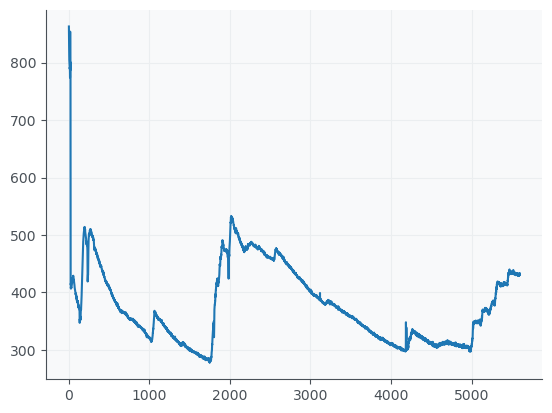

In [124]:
plt.plot( d5 )
np.mean(p3)

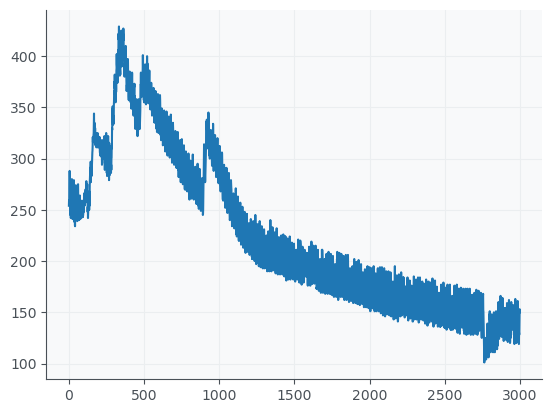

In [16]:
plt.plot( p8 )
# Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( s3 , 0.05)

In [17]:
fff = np.array( [ [1,5] , [2,6] , [ 3,7 ] , [ 4,8 ] ] )
fff = fff.reshape( (2, 4) )

fff.shape

(2, 4)

In [18]:
# plt.plot( stft[6] ) 

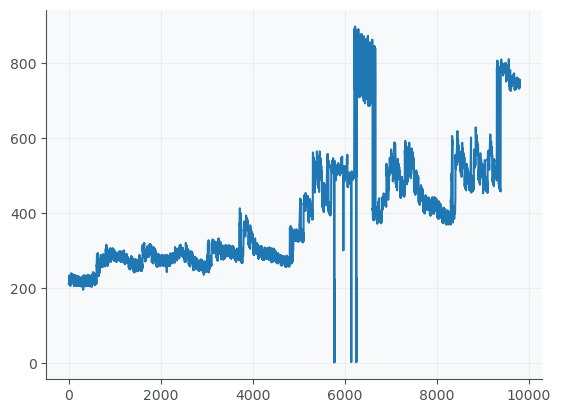

In [20]:
plt.plot( s7 )

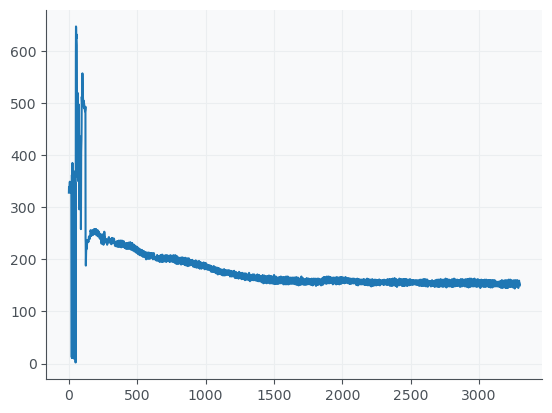

In [21]:
plt.plot(d7)

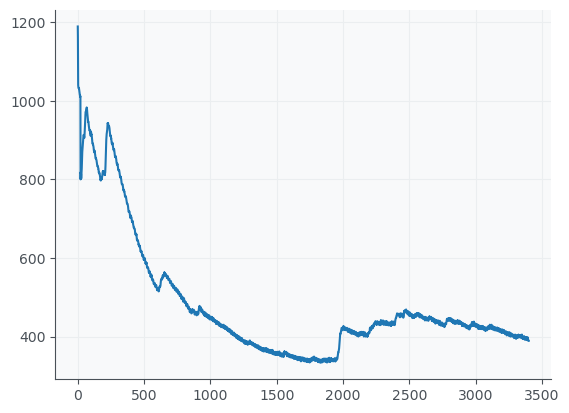

In [22]:
plt.plot(d8)

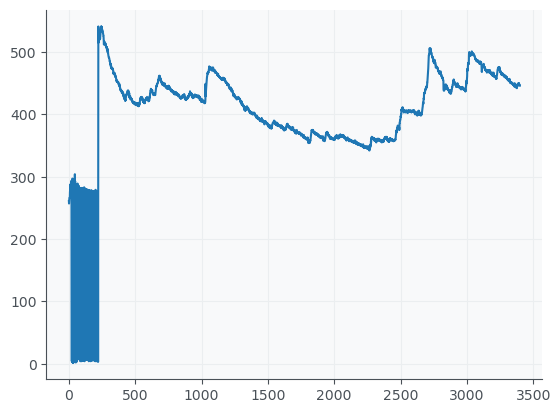

In [23]:
plt.plot(d9)

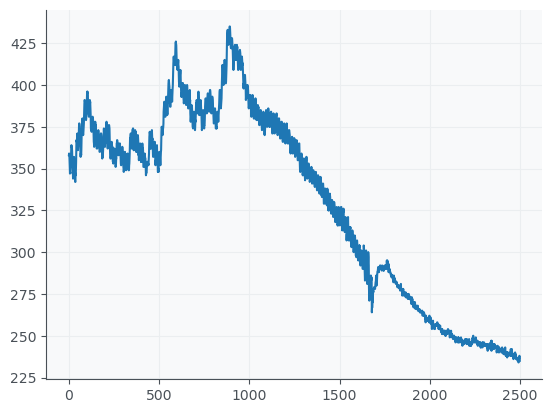

In [24]:
plt.plot(d10[100:])

# GSR processing functions

In [15]:
"""
                Not good to Extract onset and offset, so we didn't use it
                
  Make preprocessing       : Applaying FIR Low pass filter of order 50 at cutoff 1.5/Fs
                             Make Min_Max Normalization to the signal
  Extract Phasic and tonic : Using cvxEDA method from neurokit2 package                     
"""
def GSR_preprocessingAndExtractPhasicAndTonic( a_signal , a_plot=True ):
    
#     a_signal = min_max_normalization(a_signal) #First make normalization to the signal
    a_signal = apply_low_pass_filter_on_a_signal( 50 , 1.5/Fs , a_signal ) # Make a Low pass filter



    l_eda_tonic_phasic = nk.eda_phasic( a_signal , sampling_rate=Fs , method="cvxEDA"  )


    l_eda_phasic = l_eda_tonic_phasic['EDA_Phasic'].tolist()
    l_eda_tonic = l_eda_tonic_phasic['EDA_Tonic'].tolist()
    
    
    if( a_plot == True ):
        plt.subplot(3,1,1)
        plt.plot(a_signal, 'b')
        plt.subplot(3,1,1)
        plt.plot( l_eda_tonic , 'r' )
        plt.subplot(3,1,3)
        plt.plot( l_eda_phasic )
        plt.subplot(3,1,3)
        plt.plot( [0.01]*len(a_signal) )
        
    return l_eda_tonic , l_eda_phasic   


# Fs = 10
# x = Get_dataFromTextFile('serial_data_1.txt')    
# llvll,ggg = GSR_preprocessingAndExtractPhasicAndTonic(x,True)


In [16]:
"""
                      GSR_ExtractPhasicTonic_OnsetAndOffset
                      
  Make preprocessing       : Applaying FIR Low pass filter of order 50 at cutoff 1/Fs
                             Make Min_Max Normalization to the signal
 Extract Phasic and tonic  : Using neurokit method
 Extract onset and offset  : from pahsic componat of signal using threshold 0.01 of onset
                             and 0 of offset
 Extract peaks             : from cleaned data, it will extract peaks between each couple onset and offset                           
 return                    : It returns phasic, tonic, onset_offset couple and peaks
                            
"""
def GSR_ExtractPhasicTonic_OnsetAndOffset_Peaks( a_gsr_sig , a_plot=True ):
    
    l_sig =  apply_low_pass_filter_on_a_signal( 50 , 1/Fs , a_gsr_sig ) # Make a Low pass filter
#     l_sig = min_max_normalization(l_sig) # Make Normalization

    # --- Get phasic and tonic componants ---
    l_process_sig , l_process_info = nk.eda_process(  l_sig , sampling_rate=Fs , method='neurokit' )
    l_tonic  = l_process_sig['EDA_Tonic'].tolist()   # Get tonic  componant and change it to a list
    l_phasic = l_process_sig['EDA_Phasic'].tolist()  # Get phasic componant and change it to a list
    
    # cvxEDA method gives a phasic compnant from 0 to 1, no offset in it, so we didn't use it
#     l_eda_tonic_phasic = nk.eda_phasic( l_sig , sampling_rate=Fs , method="cvxEDA"  )
#     l_phasic = l_eda_tonic_phasic['EDA_Phasic'].tolist()
#     l_tonic = l_eda_tonic_phasic['EDA_Tonic'].tolist()
    
    l_phasic = l_phasic[0:] # Slice phasic componant
    l_sig = l_sig[0:]

    # --- Calculate onsets and offsets ---
    l_onset_threshold = 0.01
    l_offset_threshold=0

    # Initialize onset and offset array
    l_onset  = np.zeros( len(l_phasic) )
    l_offset = np.zeros( len(l_phasic) )

    # Onset
    for i in range( len(l_phasic) ): # Get all points that is larger than onset threshold 
        if( l_phasic[i] > l_onset_threshold ):
            l_onset[i] = i
        else:
            l_onset[i] = 0

    # Offset
    for i in range( len(l_phasic) ): # Get all points that is smaller than offset threshold 
        if( l_phasic[i] <= l_offset_threshold ):
            l_offset[i] = i
        else:
            l_offset[i] = 0

    # The next step is to couple onset and offset with each other
    l_index = 0
    l_token = 1
    l_len = max( len(l_offset) , len(l_onset) )


    l_onset_offset_couple = []  # An array that will save the onset and offset couples

    for i in range( l_len-1 ):
        if( l_token == 1 ): 
            while( l_index < len(l_onset) and l_onset[l_index] == 0 ):
                l_index = l_index + 1
    
            # A start of an onset
            l_onset_index = l_index 
            l_token = 0

        if( l_token == 0 ):
            while( l_index < len(l_offset) and l_offset[l_index] == 0 ):
                l_index = l_index + 1
  
            # couple offset with it's onset
            l_offset_index = l_index
            l_token = 1
            # Cheack if it reaches end of list
            if( l_index >= l_len-1 ):
                break  
            else :
                 l_onset_offset_couple.append( [l_onset_index,l_offset_index] ) # append couple
    
    
   
            
    # Separate onset and offset points from each other to draw them
    l_draw_onset = []
    for i in range( len(l_onset_offset_couple) ):
        l_draw_onset.append( l_onset_offset_couple[i][0] )
        
    l_draw_offset = []
    for i in range( len(l_onset_offset_couple) ):
        l_draw_offset.append( l_onset_offset_couple[i][1] )    

    # X_axis of the onset and offsets    
    l_onset_x_axis  = [l_onset_threshold]*len(l_draw_offset) 
    l_offset_x_axis = [l_offset_threshold]*len(l_draw_offset)
        

    # --- Find peaks between each onset and offset ---
    l_interval = [] # Will contain values of samples between onset and offset
    l_peaks = [] # Will contains the peaks for each onset-offset pair
    for i in range( len(l_onset_offset_couple ) ):
        l_j=0
        l_temp = l_onset_offset_couple[i][0] # Get the index of onset point

        while( l_temp < l_onset_offset_couple[i][1] ): # Loop untill reaches the corresponding offset value
            l_interval.append( l_sig[ l_temp ] ) # append the raw signal value which is between onset and offset
            l_temp+=1
        # At this point we reaches the end of onset-offset interval
        l_max_value = max(l_interval) # peak value
        l_peaks.append( [  l_temp-len(l_interval)+l_interval.index(l_max_value) , l_max_value ] ) # append the peaks index and peak value
        l_interval.clear() # Clear the interval list
        
    # Separate index of peak points from peak value in two arrays
    l_draw_peak_index = []
    l_draw_peak_value = []
    for i in range( len(l_peaks) ):
        l_draw_peak_index.append( l_peaks[i][0] ) 
        l_draw_peak_value.append( l_peaks[i][1] ) 
        
    # Draw a histogram
    l_timeForEachSample = 100
    l_draw_histogram = np.zeros( int( len(l_phasic)/(Fs*l_timeForEachSample) ) + 1 )
    for i in range( len(l_draw_peak_index) ):
        l_his_index = int( l_draw_peak_index[i]/(Fs*l_timeForEachSample) ) # Get interval of each sample
        l_draw_histogram[ l_his_index ] += 1 # increment 
        
    # Plot
    if( a_plot == True ):
        plt.subplot(3,1,1)
        plt.title('phasic')
        plt.plot(l_phasic )
        plt.scatter( l_draw_onset , l_onset_x_axis , c='r' , label='onset'   )   # Draw onsets
        plt.scatter( l_draw_offset , l_offset_x_axis , c='g' , label='offset'   ) # Draw offsets
        plt.grid()
        plt.subplot(3,1,2)
        plt.title('Raw data')
        plt.plot(l_sig , label='cleaned signal')
        plt.scatter( l_draw_peak_index , l_draw_peak_value ,c='#FF5733' , marker='x' ) 
        plt.grid()
        plt.subplot(3,1,3 )
        plt.bar( np.arange(0,len(l_draw_histogram) ) , l_draw_histogram)
        plt.grid()

        
    return l_phasic , l_draw_histogram , l_tonic , l_onset_offset_couple , l_peaks     
    
    
    
# Fs = 10    
# x = Get_dataFromTextFile('serial_data_1.txt')    
# x= kkkk

# f , g , _ , _ , _ = GSR_ExtractPhasicTonic_OnsetAndOffset_Peaks(x)    
# g

In [17]:
"""
   This function takes the phasic, onset and peaks and plot them
"""
def Plot_Phasic_with_onset_and_peaks( a_phasic , a_onset , a_peak ):
    l_ts = np.linspace(0, (len(a_phasic)-1)/16,len(a_phasic),endpoint=False)
    plt.plot(l_ts,a_phasic , label='Signal 1')
    plt.scatter(l_ts[a_peak],a_phasic[a_peak],c='r',s=10 , label='Signal 1')
    plt.scatter(l_ts[a_onset],a_phasic[a_onset],c='y',s=10 , label='Signal 1')

def Plot_orign_with_onset_and_peaks( a_orign , a_tonic , a_onset , a_peak ):
    l_ts = np.linspace(0, (len(a_orign)-1)/16,len(a_orign),endpoint=False)
    plt.plot(l_ts,a_orign,c='b')
    plt.plot(l_ts,a_tonic,c='g')
    plt.scatter(l_ts[a_peak] ,a_orign[a_peak],c='r',s=20)
    plt.scatter(l_ts[a_onset] , a_orign[a_onset],c='y',s=10)
    

In [18]:
"""
   This function is used to plot data from Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks functio
"""

def Ledapy_plot( a_orign , a_phasic , a_tonic , a_onset , a_peak):
    plt.subplot(2,1,1)
    plt.grid()
    plt.title('Phasic')
    Plot_Phasic_with_onset_and_peaks( a_phasic , a_onset , a_peak )
    
    plt.subplot(2,1,2)
    plt.grid()
    plt.title('cleaned data')
    Plot_orign_with_onset_and_peaks(  a_orign , a_tonic , a_onset , a_peak )
    plt.grid()
    plt.show()
    plt.close()
    
    
""" 
                          --Better GSR phasic Extraction Function--
                      Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime
                      
  Make preprocessing       : Applaying FIR Low pass filter of order 50 at cutoff 1.5/Fs
                             Make Min_Max Normalization to the signal
 Extract Phasic and tonic  : Using ledapy method
 Extract onset and offset  : from pahsic componat of signal using threshold 0.1 
 
 Extract peaks             : from cleaned data, it will extract peaks                      
 return                    : It returns cleaned signal , phasic , tonic , onsets , peaks, raise_time
                            
"""
def Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( a_signal , a_min_amplitude , a_plot=True ):                
    l_scrs, l_amps, l_ZC, l_pks = [], [], [], []
#     a_signal = min_max_normalization(a_signal) #First make normalization to the signal
    a_signal = apply_low_pass_filter_on_a_signal( 50 , 1/Fs , a_signal ) # Make a Low pass filter
    
    l_phasicData  = ledapy.runner.getResult( a_signal ,  'phasicdata' , sampling_rate =Fs , downsample=1 )
    l_pahsicDriver = ledapy.runner.getResult( a_signal , 'phasicdriver' , sampling_rate =Fs , downsample=1 )
    l_tonicData = a_signal - l_phasicData


    # Find zero crossings
    l_zeros = argrelextrema(l_phasicData,np.less)[0]

    l_zeros = np.insert(l_zeros,0,0) # Insert zereo at index zero
    l_zeros = np.insert(l_zeros,len(l_zeros) , len(l_phasicData)-1) # insert the last index in the array at end


    for i in range(0, len(l_zeros) - 1, 1):
        l_scrs += [ l_phasicData[l_zeros[i]:l_zeros[i + 1]+1] ]
        l_aux = l_scrs[-1].max()
        if l_aux > l_phasicData[l_zeros[i]] and l_aux > l_phasicData[l_zeros[i+1]]:
            l_amps += [l_aux-l_phasicData[l_zeros[i]]]
            l_ZC += [l_zeros[i]]
            l_ZC += [l_zeros[i + 1]]
            l_pks += [l_zeros[i] + np.argmax(l_phasicData[l_zeros[i]:l_zeros[i + 1]])]
        elif l_aux == l_phasicData[l_zeros[-1]]:
            l_amps += [l_aux-l_phasicData[l_zeros[-2]]]
            l_ZC += [l_zeros[-2]]
            l_ZC += [l_zeros[-1]]
            l_pks += [l_zeros[-1]]
    if l_amps == []:
        l_ZC += [np.argmin(l_phasicData)]
        l_amps += [np.max(l_phasicData[l_ZC[0]:])-l_phasicData[l_ZC[0]]]
        l_pks += [np.argmax(l_phasicData[l_ZC[0]:])]

    # Find the maximum length of arrays in the list
    l_max_length = max(len(l_scrs) for l_scrs in l_scrs)

    # Pad shorter arrays with zeros to make them the same length
    l_padded_scrs = [np.pad(l_scrs, (0, l_max_length - len(l_scrs)), 'constant') for l_scrs in l_scrs ]

    l_scrs = np.array(l_padded_scrs)
    l_amps = np.array(l_amps)
    l_ZC = np.array(l_ZC)
    l_pks = np.array(l_pks)
    l_onsets = l_ZC[::2]
    l_thr = a_min_amplitude * np.max(l_amps)
    l_arglow = np.where(l_amps<l_thr)
    l_amps = np.delete(l_amps,l_arglow)
    l_pks = np.delete(l_pks,l_arglow)
    l_onsets = np.delete(l_onsets,l_arglow)

    l_risingtimes = l_pks-l_onsets
    l_risingtimes = l_risingtimes/16

    l_pks = l_pks[l_risingtimes > 0.1]
    l_onsets = l_onsets[l_risingtimes > 0.1]
    l_amps = l_amps[l_risingtimes > 0.1]
    
    # Plot
    if( a_plot == True ):
        Ledapy_plot( a_signal , l_phasicData, l_tonicData , l_onsets , l_pks )

        
        
    l_rise_time = l_pks - l_onsets
    return  a_signal , l_phasicData , l_tonicData , l_onsets , l_pks , l_rise_time


# Fs = 10    
# # x = Get_dataFromTextFile('serial_data_1.txt')    
# x = kkkk
# clean_sig , ph , ton , onsets , ppk , raise_time = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime(  np.array(x) , 0.1 )

# print(ppk)
# print(onsets)
# ppk

In [19]:
# """
#    Make Short time forrier transform
#    This function takes the signal and calculate the STFT on it, and return the features for each window
   
#    return a list contains the mean of FFT for each window
   
# """
# def STFT_frequency_Features( a_signal , a_plot=True ):
    
#     l_sig =  apply_low_pass_filter_on_a_signal( 50 , 0.4/Fs , a_signal ) # Make a Low pass filter
#     l_stft = librosa.stft( l_sig , n_fft=g_window_size , hop_length=g_overlab , window='hann' )
#     l_spectogram = np.abs( l_stft ) ** 2
    
#     # Get features from spectogram 
#     l_spectogram = l_spectogram.reshape( ( l_spectogram.shape[1] , l_spectogram.shape[0] ) ) # Reshape the signal
#     l_mean_arr = []
#     print( l_spectogram.shape )

#     for i in range( 0 , l_spectogram.shape[0]  ) :
#         l_mean_arr.append( np.mean( l_spectogram[i] )/100000 )
    
#     if( a_plot ):
#         librosa.display.specshow( l_spectogram , sr=Fs , hop_length=g_overlab , x_axis='time' , y_axis='log' )
#         plt.colorbar()
    
#     return l_mean_arr
    
    
# # stft = STFT_frequency_Features( s6 , 32*2 , 16 , False )

# # print( stft.shape )

# # stft = stft.reshape( ( stft.shape[1] , stft.shape[0] ) ) # Reshape the signal

# # mean_arr = []

# # for i in range( 0 , stft.shape[1]  ) :
# #     mean_arr.append( np.mean( stft[i] )/100000 )

# # plt.plot( mean_arr )    
# # print( np.mean(mean_arr) )    
# # print( mean_arr )        


In [20]:
# STFT_frequency_Features( np.array( [1,2,3,4]*1000 )  )

In [21]:
"""
     Extract_frequency_Features
     
     This function Extracts some Freqency features from signal like FFT, PSD and Spectogram
     Return : FFT , PSD and Spectogram_Sxx

"""
def Extract_frequency_Features( a_signal , a_plot=True ):
    
    l_sig = a_signal
    l_sig = l_sig * hann( len(l_sig) ) # Multiply the signal with hann window
    
    l_sig =  apply_low_pass_filter_on_a_signal( 50 , 0.4/Fs , a_signal ) # Make a Low pass filter
#     l_sig = min_max_normalization(l_sig) # Make Normalization
#     l_sig = l_sig[30:-60]

    # Compute Fast Forrirer Transform
    l_fft_sig = np.fft.fft( l_sig )[1:]
    
    # Compute power specturn denisty of signal
    l_freq, l_psd = welch( a_signal , fs=Fs , nperseg=len(a_signal) , window='hamming'   )
    # Compute spectrogram
    l_spectogram_freq , l_spectogram_times , l_spectogram_Sxx = spectrogram( np.array(a_signal) , fs=Fs  )
    
    
    # Get freqency from 0 to 0.25HZ, because the signal power is concentrated in this range
    l_fft_sig = l_fft_sig[0 : int(np.round( (0.25/Fs)*(len(l_fft_sig)) )) ]
    l_psd     = l_psd    [0 : int(np.round( (0.25/Fs)*(len(l_psd))     )) ]
    
    l_fft_sig        =  np.real(l_fft_sig)
    l_psd            =  np.real(l_psd)
    l_spectogram_Sxx =  np.real(l_spectogram_Sxx)
    
        
    if( a_plot == True ):
        # Plot FFT signal
        plt.figure(figsize=(10, 10))
        plt.subplot(3,1,1)
        plt.title('FFT')
        l_FFT_x_axis = np.linspace( 0 , 0.25 , len(l_fft_sig)  ) # Get x_axis of FFT graph from 0 to 0.4HZ 
        plt.plot( l_FFT_x_axis , l_fft_sig )

        # Plot PSD signal
        plt.subplot(3,1,2)
        plt.title('PSD')
        plt.plot( l_psd )

        # Plot spectogram
        plt.subplot(3,1,3)
        plt.title('Spectogram')
        plt.specgram( l_sig , Fs=Fs )
        plt.colorbar()
    
    
    return l_fft_sig.tolist() , l_psd.tolist() , l_spectogram_Sxx.tolist()


# Fs = 10    
# x = Get_dataFromTextFile('serial_data_1.txt' )   
# # x = kkkk
# ff , kk , ll = Extract_frequency_Features(x) 


In [22]:
"""        
   This function takes the signal and split it into many windows to make process on each window
   a_arr     : is the my array
   a_window  : is the window size
   a_overlap : The overlab between ach window
   
   The function returns a two dimention array contains all windows
   Number of windows equal len(a_arr)/(window-overlab)
   Size of eah window equal a_window
   
   Taken from https://github.com/DebasmitaGhose/Stress-Modeling-with-GSR-and-Speech-Sensors/blob/master/GSR.py
"""
def windowed_view( a_arr, a_window_size , a_overlap):
    a_arr = np.asarray(a_arr)
    l_window_step = a_window_size - a_overlap
    l_new_shape = a_arr.shape[:-1] + ((a_arr.shape[-1] - a_overlap) // l_window_step, a_window_size)
    l_new_strides = (a_arr.strides[:-1] + (l_window_step * a_arr.strides[-1],) + a_arr.strides[-1:])
    
    return as_strided( a_arr, shape=l_new_shape, strides=l_new_strides)

In [23]:
"""
  Extract_deep_learning_features
  

    """
def Extract_deep_learning_features( a_signal ):
    
    """
    prepare_automatic
    
        inputs::
        eda_signals: All eda signals (must be normalized to 0-1 range since the activation function of last layer is sigmoid.) targeted for feature extraction (2d list: nxm, n=number of signals, m=length of each signal)
        sample_rate: sample rate which the data is collected at
        new_sample_rate: new sample rate to downsample the data to
        epochs: the number of epochs to train the autoencoder
        k: the number of automatic features to extract
        batch_size: the batch size to train the autoencoder
    """
    prepare_automatic( a_signal , sample_rate=Fs , new_sample_rate=10, k=32, epochs=100, batch_size=10)
    
    """
    Feature Extraction
       After our autoencoder is trained, we use the following function in order to extract automatic features 
       from any GSR signal using process_automatic function.
    """
    automatic_features = process_automatic(eda_signals)
    print(automatic_features)


    
# Fs = 10
# x  = Get_dataFromTextFile( 'MentalWorkLoad/watching_AI_lecture_part2.txt')
# x = apply_low_pass_filter_on_a_signal( 50 , 1/Fs , x ) # Filtering signal

# x = windowed_view( x , 10 , 1)

# Extract_deep_learning_features( x )
# plt.plot(x)

# Display some datasets

MAUS datasets

In [56]:
"""
  This function displays signals and there componant for MAUS dataset in a good view
"""

def Display_MAUS_Dataset( a_data_num ):
    
    print('**************************************************************************')
    print(f'***************************** MWL 00{a_data_num} ************************************')
    print('**************************************************************************')
    
    
    ###############################################################################################################
    ####################################### During resting 5min ###################################################
    ###############################################################################################################

    #Sampling freqency for this dataset is 100HZ for pixArt and 256HZ for inf
    Fs = 256   # sampling 
    if( a_data_num <= 9 ):
        l_Resting = Get_dataFromExcel( f'../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/00{a_data_num}/inf_resting.csv','Resting_GSR')
    else:
        l_Resting = Get_dataFromExcel(  f'../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/0{a_data_num}/inf_resting.csv','Resting_GSR')

    # Clean and Extract some time domain features
    l_r_clean_sig , l_r_Phasic , l_r_tonic , l_r_onset , l_r_peaks , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( l_Resting , 0.05 , a_plot=False )

    plt.figure(figsize=(20, 20))
    # Plot cleaned data
    plt.subplot( 3 , 7 , 1  )
    plt.title('Resting cleaned GSR ')
    plt.plot(l_r_clean_sig)
    # Plot Phasic componants with onsets and peaks
    plt.subplot( 3 , 7 , 8 )
    plt.title('Resting Phasic')
    Plot_Phasic_with_onset_and_peaks( l_r_Phasic , l_r_onset , l_r_peaks )
    # plot freqency componants
    l_r_FFT , l_r_PSD , _ = Extract_frequency_Features( l_r_Phasic , a_plot=False )
    plt.subplot( 3 , 7 , 15 )
    plt.title('Resting FFT')
    plt.plot(l_r_FFT)
    print( f"FFT at resting = {np.mean(l_r_FFT)}")
    l_sympathetic =  nk.eda_sympathetic( l_r_clean_sig , sampling_rate=Fs )['EDA_Sympathetic'] 
    print( f'sympathetic at resting = { l_sympathetic }' )
    l_sympatheticN = nk.eda_sympathetic( l_r_clean_sig , sampling_rate=Fs )['EDA_SympatheticN']
    print( f'sympatheticN at resting = { l_sympatheticN } \n' )
          
 
    ##########################################################################################################################
    ####################################### During Mental work load Trial1 ###################################################
    ##########################################################################################################################

    if( a_data_num <= 9 ):
        l_MWL = Get_dataFromExcel( f'../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/00{a_data_num}/inf_gsr.csv','Trial 1:0back' )
    else:
        l_MWL = Get_dataFromExcel( f'../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/0{a_data_num}/inf_gsr.csv','Trial 1:0back' )

    l_m_clean_sig , l_m_Phasic , l_m_tonic , l_m_onset , l_m_peaks , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( l_MWL , 0.05 , a_plot=False )

    # Plot cleaned data
    plt.subplot( 3 , 7 , 2  )
    plt.title('MWL GSR trial1:0 Raw data')
    plt.plot(l_m_clean_sig)
    # Plot Phasic componants with onsets and peaks
    plt.subplot( 3 , 7 , 9 )
    plt.title('MWL Phasic')
    Plot_Phasic_with_onset_and_peaks( l_m_Phasic , l_m_onset , l_m_peaks )
    # plot freqency componants
    l_m_FFT , l_m_PSD , _ = Extract_frequency_Features( l_m_Phasic , a_plot=False )
    plt.subplot( 3 , 7 , 16 )
    plt.title('MWL FFT')
    plt.plot(l_m_FFT)
    print( f"FFT at MWL trial1:0= {np.mean(l_m_FFT)}")
    l_sympathetic =  nk.eda_sympathetic( l_m_clean_sig , sampling_rate=Fs )['EDA_Sympathetic'] 
    print( f'sympathetic = { l_sympathetic }' )
    l_sympatheticN = nk.eda_sympathetic( l_m_clean_sig , sampling_rate=Fs )['EDA_SympatheticN'] 
    print( f'sympatheticN = { l_sympatheticN } \n' )


    ##########################################################################################################################
    ####################################### During Mental work load Trial2 ###################################################
    ##########################################################################################################################

    if( a_data_num <= 9 ):
        l_MWL = Get_dataFromExcel( f'../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/00{a_data_num}/inf_gsr.csv','Trial 2:2back' )
    else:
        l_MWL = Get_dataFromExcel( f'../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/0{a_data_num}/inf_gsr.csv','Trial 2:2back' )

    l_m_clean_sig , l_m_Phasic , l_m_tonic , l_m_onset , l_m_peaks , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( l_MWL , 0.05 , a_plot=False )

    # Plot cleaned data
    plt.subplot( 3 , 7 , 3  )
    plt.title('MWL GSR trial2:2 Raw data')
    plt.plot(l_m_clean_sig)
    # Plot Phasic componants with onsets and peaks
    plt.subplot( 3 , 7 , 10 )
    plt.title('MWL Phasic')
    Plot_Phasic_with_onset_and_peaks( l_m_Phasic , l_m_onset , l_m_peaks )
    # plot freqency componants
    l_m_FFT , l_m_PSD , _ = Extract_frequency_Features( l_m_Phasic , a_plot=False )
    plt.subplot( 3 , 7 , 17 )
    plt.title('MWL FFT')
    plt.plot(l_m_FFT)
    print( f"FFT at MWL trial2:2= {np.mean(l_m_FFT)}")
    l_sympathetic =  nk.eda_sympathetic( l_m_clean_sig , sampling_rate=Fs )['EDA_Sympathetic'] 
    print( f'sympathetic = { l_sympathetic }' )
    l_sympatheticN = nk.eda_sympathetic( l_m_clean_sig , sampling_rate=Fs )['EDA_SympatheticN'] 
    print( f'sympatheticN = { l_sympatheticN } \n' )

    ##########################################################################################################################
    ####################################### During Mental work load Trial3 ###################################################
    ##########################################################################################################################

    if( a_data_num <= 9 ):
        l_MWL = Get_dataFromExcel( f'../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/00{a_data_num}/inf_gsr.csv','Trial 3:3back' )
    else:
        l_MWL = Get_dataFromExcel( f'../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/0{a_data_num}/inf_gsr.csv','Trial 3:3back' )

    l_m_clean_sig , l_m_Phasic , l_m_tonic , l_m_onset , l_m_peaks , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( l_MWL , 0.05 , a_plot=False )

    # Plot cleaned data
    plt.subplot( 3 , 7 , 4  )
    plt.title('MWL GSR trial3:3 Raw data')
    plt.plot(l_m_clean_sig)
    # Plot Phasic componants with onsets and peaks
    plt.subplot( 3 , 7 , 11 )
    plt.title('MWL Phasic')
    Plot_Phasic_with_onset_and_peaks( l_m_Phasic , l_m_onset , l_m_peaks )
    # plot freqency componants
    l_m_FFT , l_m_PSD , _ = Extract_frequency_Features( l_m_Phasic , a_plot=False )
    plt.subplot( 3 , 7 , 18 )
    plt.title('MWL FFT')
    plt.plot(l_m_FFT)
    print( f"FFT at MWL trial3:3= {np.mean(l_m_FFT)}")
    l_sympathetic =  nk.eda_sympathetic( l_m_clean_sig , sampling_rate=Fs )['EDA_Sympathetic'] 
    print( f'sympathetic = { l_sympathetic }' )
    l_sympatheticN = nk.eda_sympathetic( l_m_clean_sig , sampling_rate=Fs )['EDA_SympatheticN'] 
    print( f'sympatheticN = { l_sympatheticN } \n' )

    
    
    ##########################################################################################################################
    ####################################### During Mental work load Trial4 ###################################################
    ##########################################################################################################################

    if( a_data_num <= 9 ):
        l_MWL = Get_dataFromExcel( f'../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/00{a_data_num}/inf_gsr.csv','Trial 4:2back' )
    else:
        l_MWL = Get_dataFromExcel( f'../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/0{a_data_num}/inf_gsr.csv','Trial 4:2back' )

    l_m_clean_sig , l_m_Phasic , l_m_tonic , l_m_onset , l_m_peaks , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( l_MWL , 0.05 , a_plot=False )

    # Plot cleaned data
    plt.subplot( 3 , 7 , 5  )
    plt.title('MWL GSR trial4:2 Raw data')
    plt.plot(l_m_clean_sig)
    # Plot Phasic componants with onsets and peaks
    plt.subplot( 3 , 7 , 12 )
    plt.title('MWL Phasic')
    Plot_Phasic_with_onset_and_peaks( l_m_Phasic , l_m_onset , l_m_peaks )
    # plot freqency componants
    l_m_FFT , l_m_PSD , _ = Extract_frequency_Features( l_m_Phasic , a_plot=False )
    plt.subplot( 3 , 7 , 19 )
    plt.title('MWL FFT')
    plt.plot(l_m_FFT)
    print( f"FFT at MWL trial4:2= {np.mean(l_m_FFT)}")
    l_sympathetic =  nk.eda_sympathetic( l_m_clean_sig , sampling_rate=Fs )['EDA_Sympathetic'] 
    print( f'sympathetic = { l_sympathetic }' )
    l_sympatheticN = nk.eda_sympathetic( l_m_clean_sig , sampling_rate=Fs )['EDA_SympatheticN'] 
    print( f'sympatheticN = { l_sympatheticN } \n' )
    
    
    
    ##########################################################################################################################
    ####################################### During Mental work load Trial5 ###################################################
    ##########################################################################################################################

    if( a_data_num <= 9 ):
        l_MWL = Get_dataFromExcel( f'../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/00{a_data_num}/inf_gsr.csv','Trial 5:3back' )
    else:
        l_MWL = Get_dataFromExcel( f'../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/0{a_data_num}/inf_gsr.csv','Trial 5:3back' )

    l_m_clean_sig , l_m_Phasic , l_m_tonic , l_m_onset , l_m_peaks , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( l_MWL , 0.05 , a_plot=False )

    # Plot cleaned data
    plt.subplot( 3 , 7 , 6  )
    plt.title('MWL GSR trial5:3 Raw data')
    plt.plot(l_m_clean_sig)
    # Plot Phasic componants with onsets and peaks
    plt.subplot( 3 , 7 , 13 )
    plt.title('MWL Phasic')
    Plot_Phasic_with_onset_and_peaks( l_m_Phasic , l_m_onset , l_m_peaks )
    # plot freqency componants
    l_m_FFT , l_m_PSD , _ = Extract_frequency_Features( l_m_Phasic , a_plot=False )
    plt.subplot( 3 , 7 , 20 )
    plt.title('MWL FFT')
    plt.plot(l_m_FFT)
    print( f"FFT at MWL trial5:3= {np.mean(l_m_FFT)}")
    l_sympathetic =  nk.eda_sympathetic( l_m_clean_sig , sampling_rate=Fs )['EDA_Sympathetic'] 
    print( f'sympathetic = { l_sympathetic }' )
    l_sympatheticN = nk.eda_sympathetic( l_m_clean_sig , sampling_rate=Fs )['EDA_SympatheticN'] 
    print( f'sympatheticN = { l_sympatheticN } \n' )
    
    
    
    
    ##########################################################################################################################
    ####################################### During Mental work load Trial6 ###################################################
    ##########################################################################################################################

    if( a_data_num <= 9 ):
        l_MWL = Get_dataFromExcel( f'../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/00{a_data_num}/inf_gsr.csv','Trial 6:0back' )
    else:
        l_MWL = Get_dataFromExcel( f'../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/0{a_data_num}/inf_gsr.csv','Trial 6:0back' )

    l_m_clean_sig , l_m_Phasic , l_m_tonic , l_m_onset , l_m_peaks , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( l_MWL , 0.05 , a_plot=False )

    # Plot cleaned data
    plt.subplot( 3 , 7 , 7  )
    plt.title('MWL GSR trial6:0 Raw data')
    plt.plot(l_m_clean_sig)
    # Plot Phasic componants with onsets and peaks
    plt.subplot( 3 , 7 , 14 )
    plt.title('MWL Phasic')
    Plot_Phasic_with_onset_and_peaks( l_m_Phasic , l_m_onset , l_m_peaks )
    # plot freqency componants
    l_m_FFT , l_m_PSD , _ = Extract_frequency_Features( l_m_Phasic , a_plot=False )
    plt.subplot( 3 , 7 , 21 )
    plt.title('MWL FFT')
    plt.plot(l_m_FFT)
    print( f"FFT at MWL trial6:0= {np.mean(l_m_FFT)}")
    l_sympathetic =  nk.eda_sympathetic( l_m_clean_sig , sampling_rate=Fs )['EDA_Sympathetic'] 
    print( f'sympathetic = { l_sympathetic }' )
    l_sympatheticN = nk.eda_sympathetic( l_m_clean_sig , sampling_rate=Fs )['EDA_SympatheticN'] 
    print( f'sympatheticN = { l_sympatheticN } \n' )

**************************************************************************
***************************** MWL 002 ************************************
**************************************************************************
FFT at resting = 11.115596524714274
sympathetic at resting = 0.012393593835539469
sympatheticN at resting = 0.00743649589907412 

FFT at MWL trial1:0= 15.851910543610037
sympathetic = 0.00952039577071088
sympatheticN = 0.002369573017192097 

FFT at MWL trial2:2= 20.434735060263975
sympathetic = 0.02407389916978655
sympatheticN = 0.002902809285025584 

FFT at MWL trial3:3= 32.05693782208437
sympathetic = 0.02183096811690708
sympatheticN = 0.0017460043495393291 

FFT at MWL trial4:2= 29.901869021762288
sympathetic = 0.011356359458291214
sympatheticN = 0.0012286180751894544 

FFT at MWL trial5:3= 30.609797209708926
sympathetic = 0.03454650062193264
sympatheticN = 0.0029787649159993554 

FFT at MWL trial6:0= 28.20375466395701
sympathetic = 0.003932559188835205
sympathe

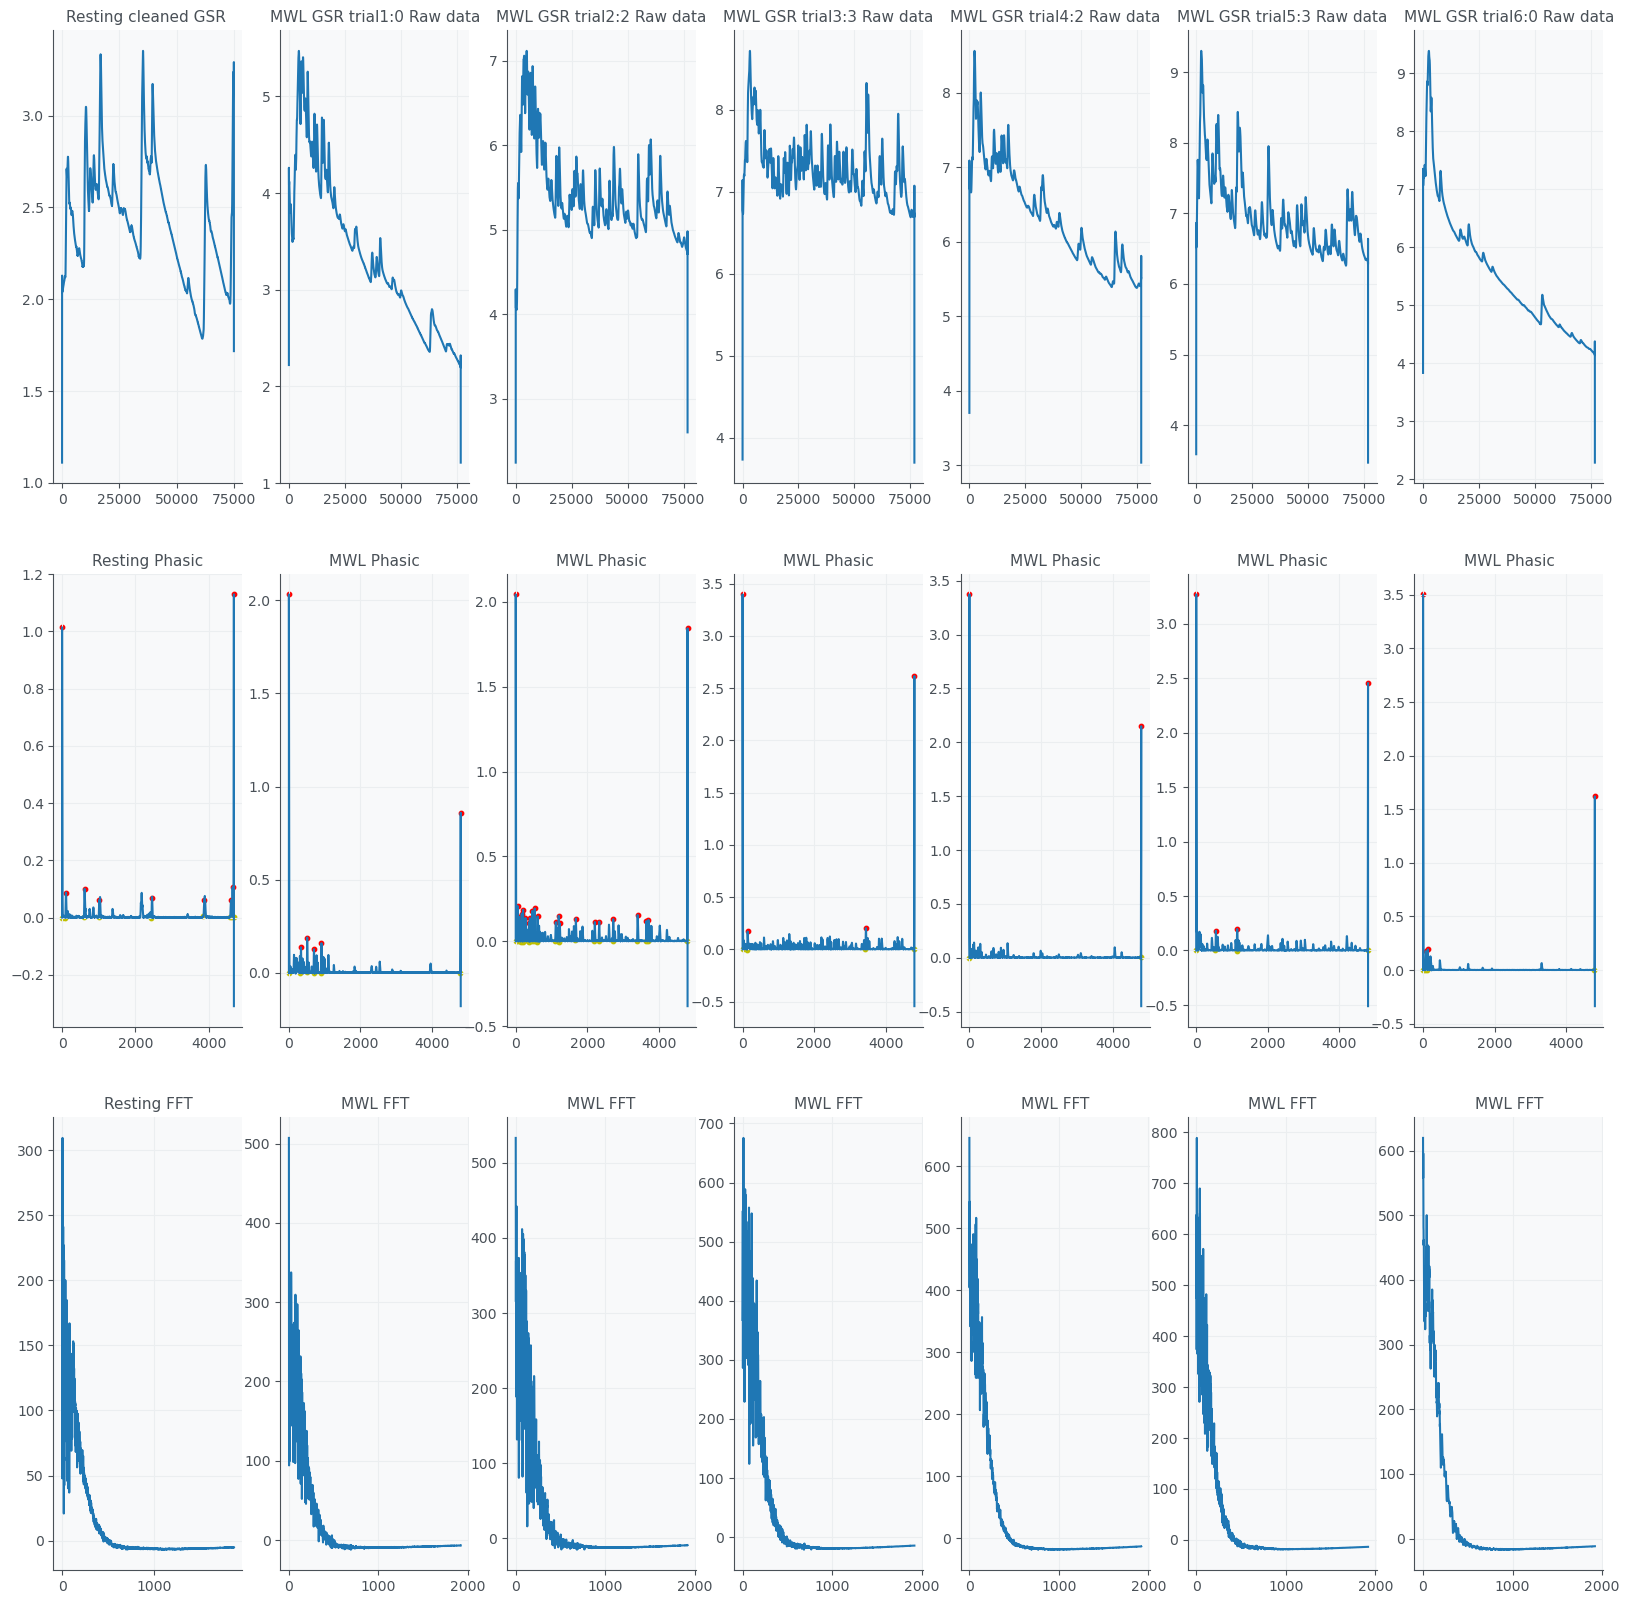

In [57]:
Display_MAUS_Dataset(2)

**************************************************************************
***************************** MWL 004 ************************************
**************************************************************************
FFT at resting = 5.934017659623086
sympathetic at resting = 0.00026938628177263527
sympatheticN at resting = 0.0018239615042369773 

FFT at MWL trial1:0= 5.578130700668595
sympathetic = 0.00026335275373723534
sympatheticN = 0.0016608281790974758 

FFT at MWL trial2:2= 7.164254684241649
sympathetic = 9.486426028952669e-05
sympatheticN = 0.00021695731508980195 

FFT at MWL trial3:3= 5.573303477570681
sympathetic = 0.0003450514401627629
sympatheticN = 0.0013739583481585755 

FFT at MWL trial4:2= 6.564082969031768
sympathetic = 0.0015967118346164857
sympatheticN = 0.00387414221477253 

FFT at MWL trial5:3= 6.544246474782548
sympathetic = 0.0003438780198885452
sympatheticN = 0.000895986784467846 

FFT at MWL trial6:0= 5.861525359388669
sympathetic = 0.000577770656717699

'\n**************************************************************************\n***************************** MWL 004 ************************************\n**************************************************************************\nPSD at resting = 3.5394712198544606e-06\nsympathetic at resting = 2.6913690479455382e-08\nsympatheticN at resting = 0.0018229785588802117 \n\nPSD at MWL trial1:0= 1.9263283396732676e-06\nsympathetic = 2.630451985242926e-08\nsympatheticN = 0.0016591926422044807 \n\nPSD at MWL trial2:2= 9.265221982247342e-07\nsympathetic = 9.480948321363775e-09\nsympatheticN = 0.00021688073011955083 \n\nPSD at MWL trial3:3= 1.6550345282257416e-06\nsympathetic = 3.447991148271177e-08\nsympatheticN = 0.001373358094682585 \n\nPSD at MWL trial4:2= 1.8096462157365387e-05\nsympathetic = 1.5950978114834864e-07\nsympatheticN = 0.00387105309824655 \n\nPSD at MWL trial5:3= 1.3809885739324689e-06\nsympathetic = 3.4357649292400716e-08\nsympatheticN = 0.0008954265733853939 \n\nPSD at MWL tr

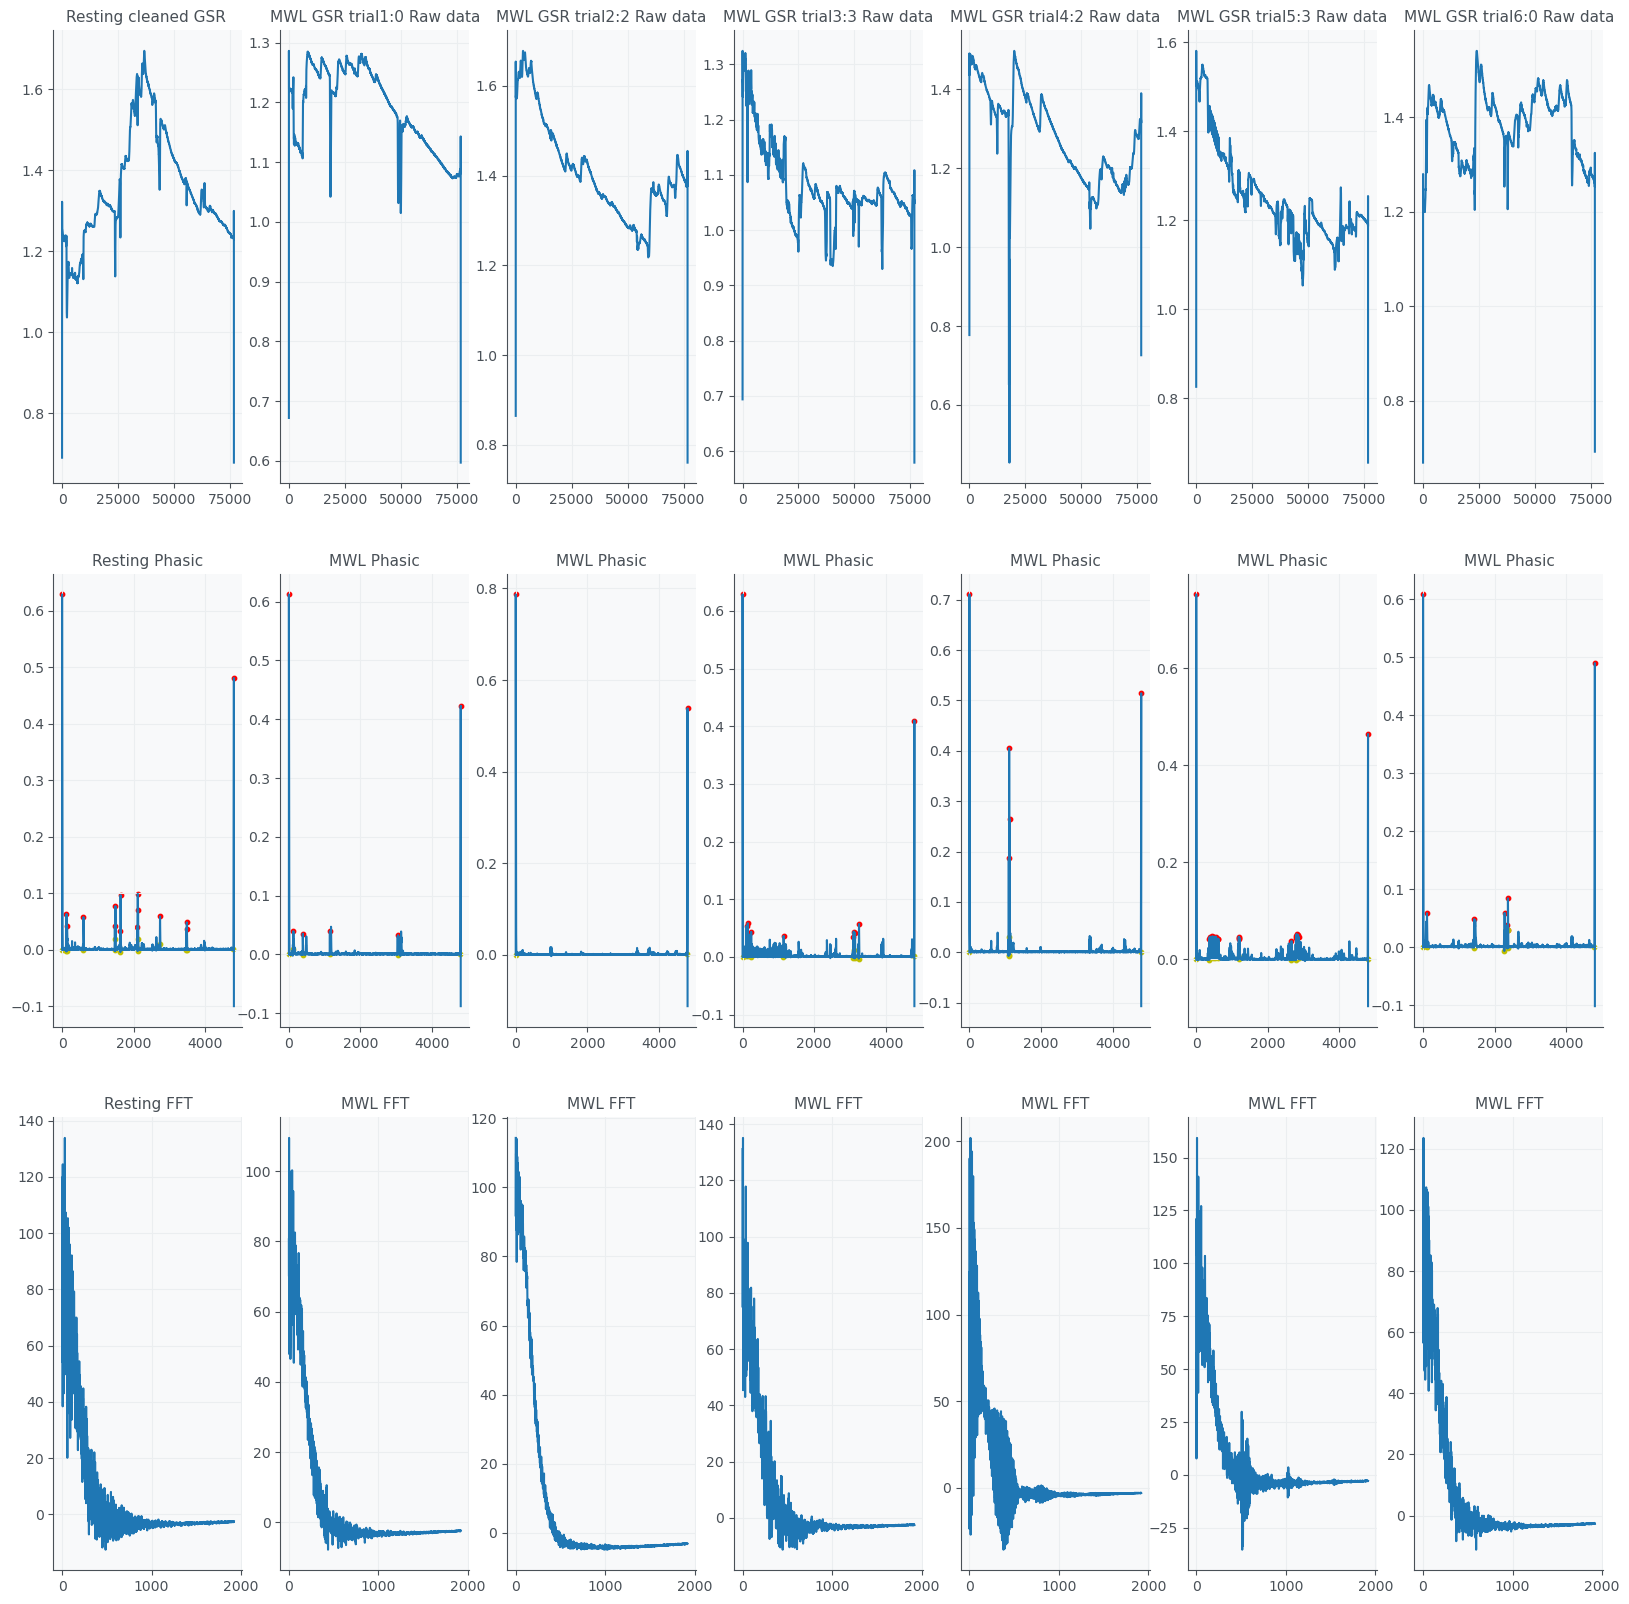

In [58]:
Display_MAUS_Dataset(4)  

"""
**************************************************************************
***************************** MWL 004 ************************************
**************************************************************************
PSD at resting = 3.5394712198544606e-06
sympathetic at resting = 2.6913690479455382e-08
sympatheticN at resting = 0.0018229785588802117 

PSD at MWL trial1:0= 1.9263283396732676e-06
sympathetic = 2.630451985242926e-08
sympatheticN = 0.0016591926422044807 

PSD at MWL trial2:2= 9.265221982247342e-07
sympathetic = 9.480948321363775e-09
sympatheticN = 0.00021688073011955083 

PSD at MWL trial3:3= 1.6550345282257416e-06
sympathetic = 3.447991148271177e-08
sympatheticN = 0.001373358094682585 

PSD at MWL trial4:2= 1.8096462157365387e-05
sympathetic = 1.5950978114834864e-07
sympatheticN = 0.00387105309824655 

PSD at MWL trial5:3= 1.3809885739324689e-06
sympathetic = 3.4357649292400716e-08
sympatheticN = 0.0008954265733853939 

PSD at MWL trial6:0= 2.5467633661399e-06
sympathetic = 5.7728016058275454e-08
sympatheticN = 0.001495548955716031 
"""

**************************************************************************
***************************** MWL 005 ************************************
**************************************************************************
FFT at resting = 7.394011602801411
sympathetic at resting = 0.0010160359114430601
sympatheticN at resting = 0.0033259680729262027 

FFT at MWL trial1:0= 9.710427074165576
sympathetic = 0.01826434342353565
sympatheticN = 0.007059073199537638 

FFT at MWL trial2:2= 16.550448017717677
sympathetic = 0.030542254079886474
sympatheticN = 0.006216024100821035 

FFT at MWL trial3:3= 19.717329062259605
sympathetic = 0.03485719058370168
sympatheticN = 0.004991743152341093 

FFT at MWL trial4:2= 23.676512263652054
sympathetic = 0.0407264826156884
sympatheticN = 0.007866939976614312 

FFT at MWL trial5:3= 21.20642252895526
sympathetic = 0.026336284524224696
sympatheticN = 0.005413964677551596 

FFT at MWL trial6:0= 19.843094205289596
sympathetic = 0.0008657743384560603
sympathe

'\nPSD at resting = 2.395882854465264e-06\nsympathetic at resting = 1.0153363299336606e-07\nsympatheticN at resting = 0.003324546275216241 \n\nPSD at MWL trial1:0= 1.833008251688991e-05\nsympathetic = 1.8246036100944798e-06\nsympatheticN = 0.007052196881379588 \n\nPSD at MWL trial2:2= 4.0231759085683364e-05\nsympathetic = 3.0516063120372277e-06\nsympatheticN = 0.006211562305872976 \n\nPSD at MWL trial3:3= 3.700755200518272e-05\nsympathetic = 3.4820636697683287e-06\nsympatheticN = 0.00498676090133615 \n\nPSD at MWL trial4:2= 6.70342375856019e-05\nsympathetic = 4.06906372301921e-06\nsympatheticN = 0.007861689623194492 \n\nPSD at MWL trial5:3= 3.194011989986441e-05\nsympathetic = 2.6319719471152333e-06\nsympatheticN = 0.005411485936000559 \n\nPSD at MWL trial6:0= 4.123286221553593e-06\nsympathetic = 8.652635600201636e-08\nsympatheticN = 0.0003965493997315858 \n'

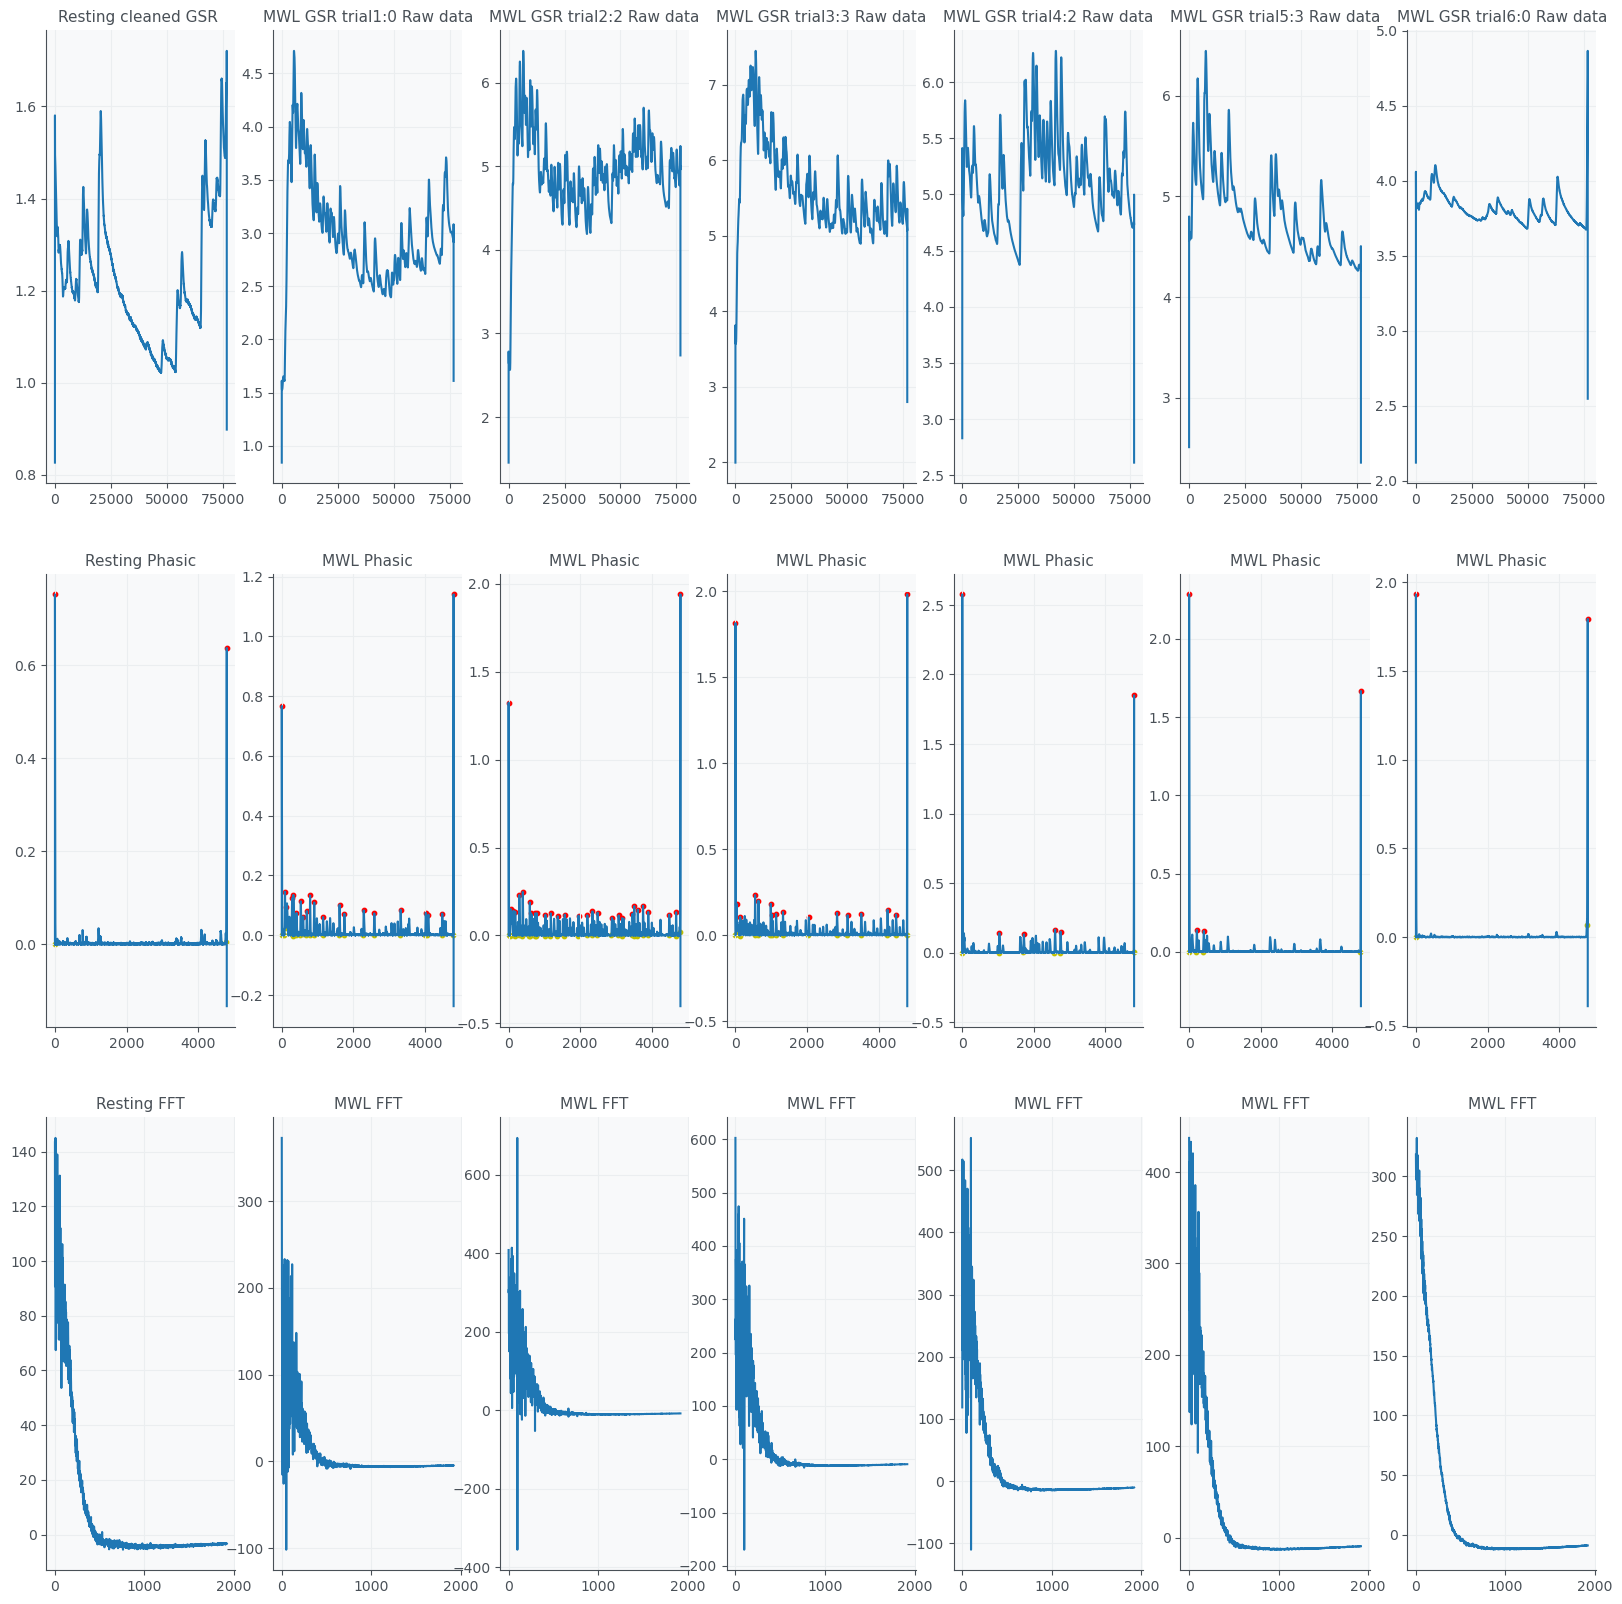

In [59]:
Display_MAUS_Dataset(5)

"""
PSD at resting = 2.395882854465264e-06
sympathetic at resting = 1.0153363299336606e-07
sympatheticN at resting = 0.003324546275216241 

PSD at MWL trial1:0= 1.833008251688991e-05
sympathetic = 1.8246036100944798e-06
sympatheticN = 0.007052196881379588 

PSD at MWL trial2:2= 4.0231759085683364e-05
sympathetic = 3.0516063120372277e-06
sympatheticN = 0.006211562305872976 

PSD at MWL trial3:3= 3.700755200518272e-05
sympathetic = 3.4820636697683287e-06
sympatheticN = 0.00498676090133615 

PSD at MWL trial4:2= 6.70342375856019e-05
sympathetic = 4.06906372301921e-06
sympatheticN = 0.007861689623194492 

PSD at MWL trial5:3= 3.194011989986441e-05
sympathetic = 2.6319719471152333e-06
sympatheticN = 0.005411485936000559 

PSD at MWL trial6:0= 4.123286221553593e-06
sympathetic = 8.652635600201636e-08
sympatheticN = 0.0003965493997315858 
"""

**************************************************************************
***************************** MWL 008 ************************************
**************************************************************************
FFT at resting = 0.29466688280484615
sympathetic at resting = 1.8737317471708466e-07
sympatheticN at resting = 0.00038818206882562374 

FFT at MWL trial1:0= 0.48637476099861504
sympathetic = 1.8105164840780326e-07
sympatheticN = 0.00014727429873761068 

FFT at MWL trial2:2= 1.149303730653586
sympathetic = 3.9727631966015843e-07
sympatheticN = 5.94986014185387e-05 

FFT at MWL trial3:3= 1.9556743654529507
sympathetic = 3.054351605068643e-06
sympatheticN = 0.00015504851211378464 

FFT at MWL trial4:2= 2.8832096283120006
sympathetic = 1.3384460010598989e-05
sympatheticN = 0.00033015479301019813 

FFT at MWL trial5:3= 3.4848742490063334
sympathetic = 3.3732980409205055e-05
sympatheticN = 0.00045966426133061186 

FFT at MWL trial6:0= 4.015072531074817
sympathetic = 2.66

'\nPSD at resting = 7.423754041956419e-10\nsympathetic at resting = 1.871721741177282e-11\nsympatheticN at resting = 0.0003878713967480731 \n\nPSD at MWL trial1:0= 1.7170568685307107e-09\nsympathetic = 1.8089624634343436e-11\nsympatheticN = 0.00014718026927529933 \n\nPSD at MWL trial2:2= 9.635092301318985e-09\nsympathetic = 3.9693402567894426e-11\nsympatheticN = 5.94634870869237e-05 \n\nPSD at MWL trial3:3= 2.6452150944390347e-08\nsympathetic = 3.051724780250078e-10\nsympatheticN = 0.00015495583778792424 \n\nPSD at MWL trial4:2= 6.956835478116464e-08\nsympathetic = 1.337429931865641e-09\nsympatheticN = 0.0003300010879815779 \n\nPSD at MWL trial5:3= 1.2395033330215548e-07\nsympathetic = 3.3708446011044513e-09\nsympatheticN = 0.00045945337104874443 \n\nPSD at MWL trial6:0= 1.4929332017712558e-07\nsympathetic = 2.6598084961651502e-09\nsympatheticN = 0.00027684559710231183 \n'

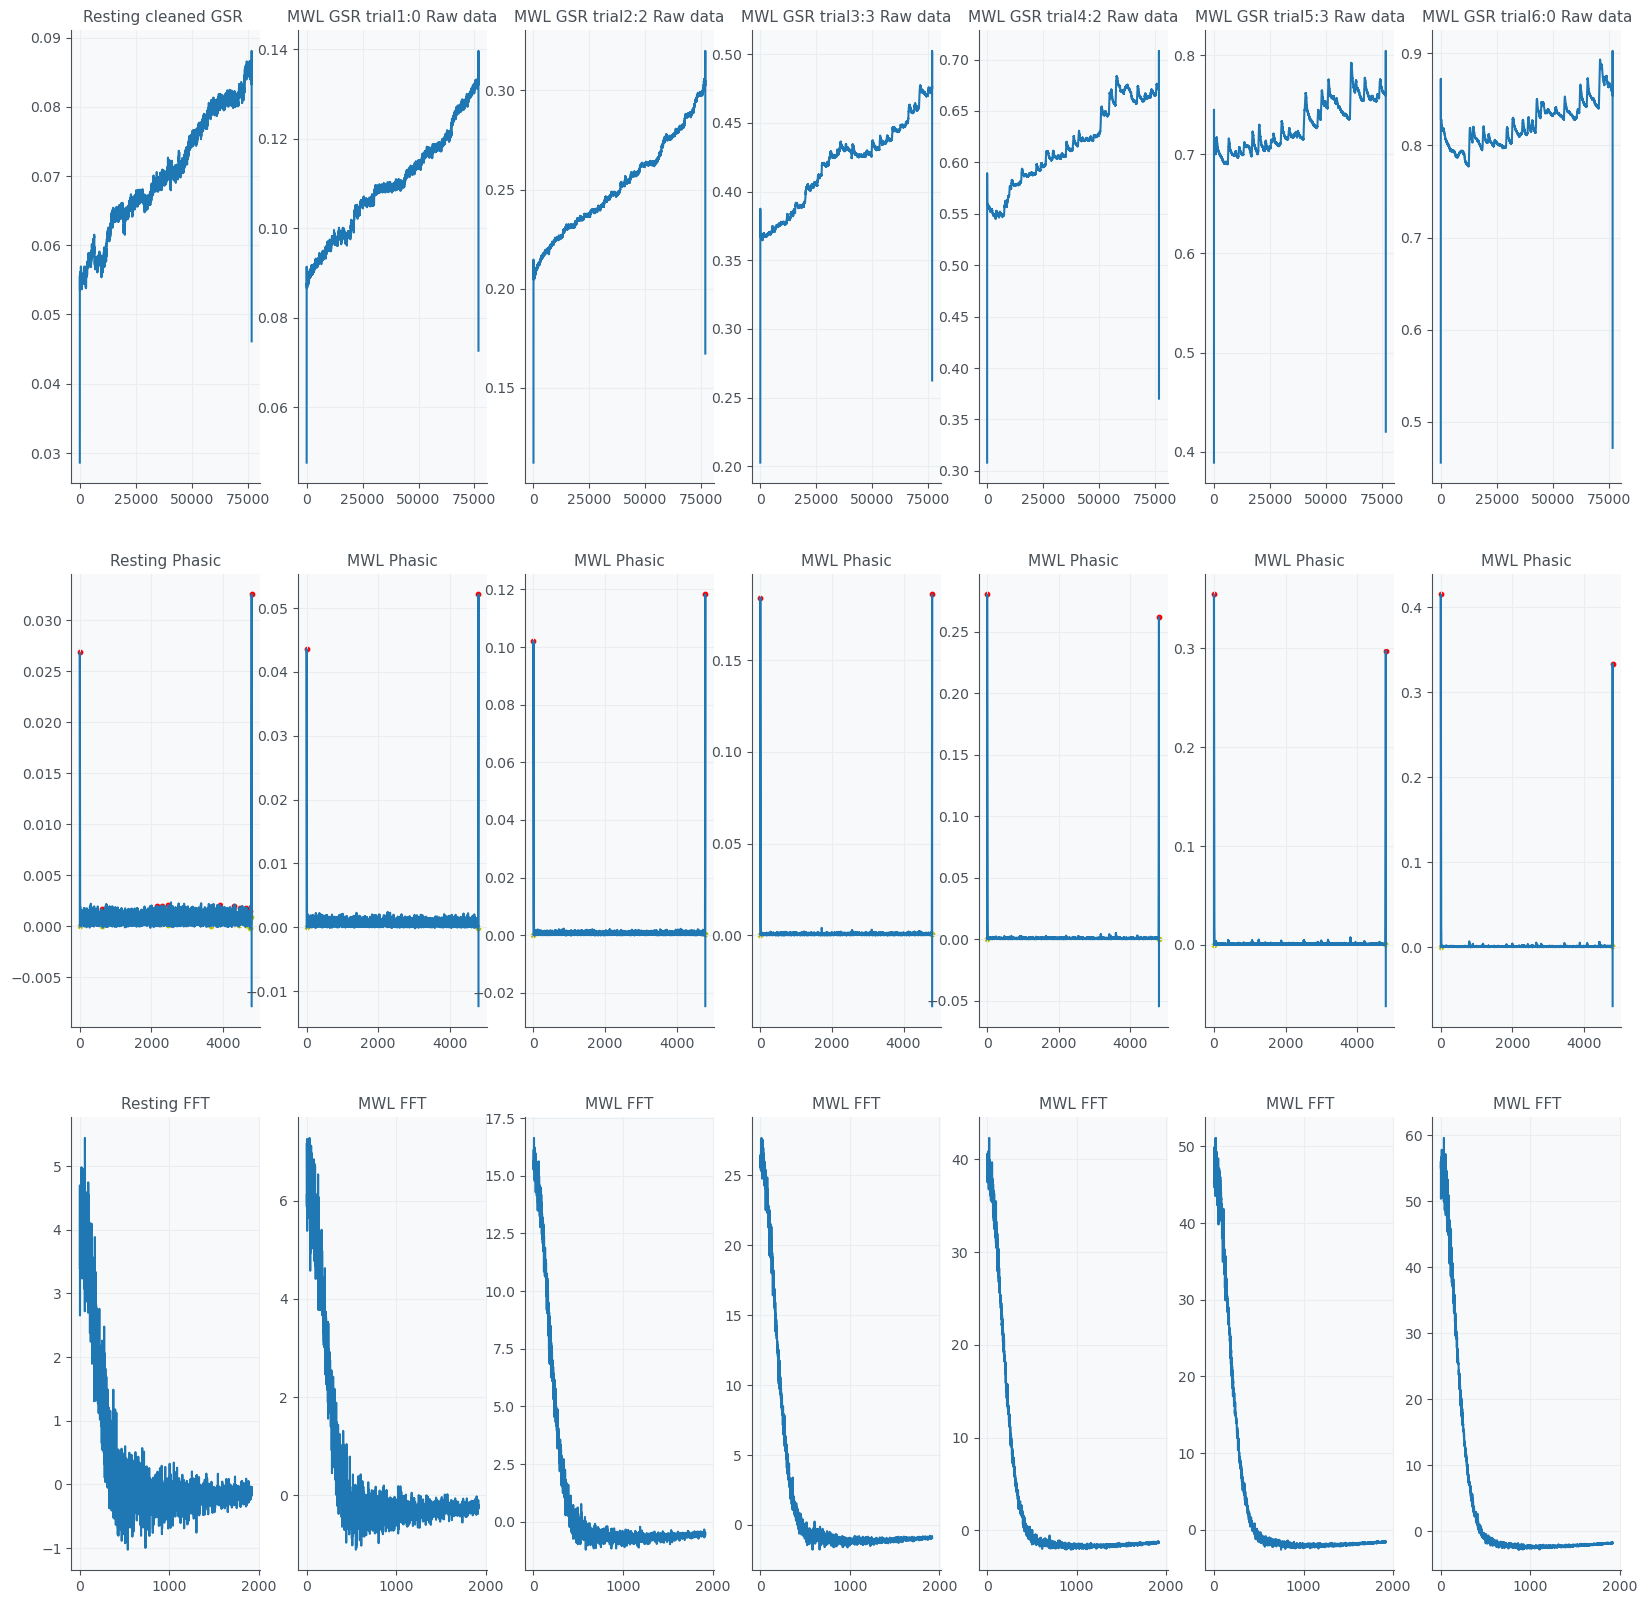

In [60]:
Display_MAUS_Dataset(8) 
"""
PSD at resting = 7.423754041956419e-10
sympathetic at resting = 1.871721741177282e-11
sympatheticN at resting = 0.0003878713967480731 

PSD at MWL trial1:0= 1.7170568685307107e-09
sympathetic = 1.8089624634343436e-11
sympatheticN = 0.00014718026927529933 

PSD at MWL trial2:2= 9.635092301318985e-09
sympathetic = 3.9693402567894426e-11
sympatheticN = 5.94634870869237e-05 

PSD at MWL trial3:3= 2.6452150944390347e-08
sympathetic = 3.051724780250078e-10
sympatheticN = 0.00015495583778792424 

PSD at MWL trial4:2= 6.956835478116464e-08
sympathetic = 1.337429931865641e-09
sympatheticN = 0.0003300010879815779 

PSD at MWL trial5:3= 1.2395033330215548e-07
sympathetic = 3.3708446011044513e-09
sympatheticN = 0.00045945337104874443 

PSD at MWL trial6:0= 1.4929332017712558e-07
sympathetic = 2.6598084961651502e-09
sympatheticN = 0.00027684559710231183 
"""

**************************************************************************
***************************** MWL 0010 ************************************
**************************************************************************
FFT at resting = 3.6481700790546787
sympathetic at resting = 4.828261974858638e-06
sympatheticN at resting = 4.274116912341551e-05 

FFT at MWL trial1:0= 2.9860896760714
sympathetic = 1.25020279088428e-06
sympatheticN = 2.082845713443071e-05 

FFT at MWL trial2:2= 7.004629385634695
sympathetic = 0.0004311855866735568
sympatheticN = 0.001567609462207784 

FFT at MWL trial3:3= 10.815091407786946
sympathetic = 0.00043333939662239967
sympatheticN = 0.0004144530615752836 

FFT at MWL trial4:2= 18.618155093269685
sympathetic = 0.0017402508484245089
sympatheticN = 0.0008793949174159422 

FFT at MWL trial5:3= 19.41287039422461
sympathetic = 0.004232226925514474
sympatheticN = 0.0015539097056593918 

FFT at MWL trial6:0= 22.219532406563097
sympathetic = 0.00045915774336711

'\nPSD at resting = 1.3874784278381655e-07\nsympathetic at resting = 4.82476849203525e-10\nsympatheticN at resting = 4.272102426996504e-05 \n\nPSD at MWL trial1:0= 7.060856389092218e-08\nsympathetic = 1.2494432526394743e-10\nsympatheticN = 2.0821256135605644e-05 \n\nPSD at MWL trial2:2= 8.698612852313582e-07\nsympathetic = 4.308718170513909e-08\nsympatheticN = 0.0015668434747357174 \n\nPSD at MWL trial3:3= 3.2325799937377627e-06\nsympathetic = 4.331123999319673e-08\nsympatheticN = 0.0004143270083126932 \n\nPSD at MWL trial4:2= 8.505738178858206e-06\nsympathetic = 1.7387944922536265e-07\nsympatheticN = 0.0008789220996265434 \n\nPSD at MWL trial5:3= 9.883710736090778e-06\nsympathetic = 4.2297322879321495e-07\nsympatheticN = 0.0015533792078094501 \n\nPSD at MWL trial6:0= 4.852666064119653e-06\nsympathetic = 4.5890274231074364e-08\nsympatheticN = 0.00011308917283051185 \n'

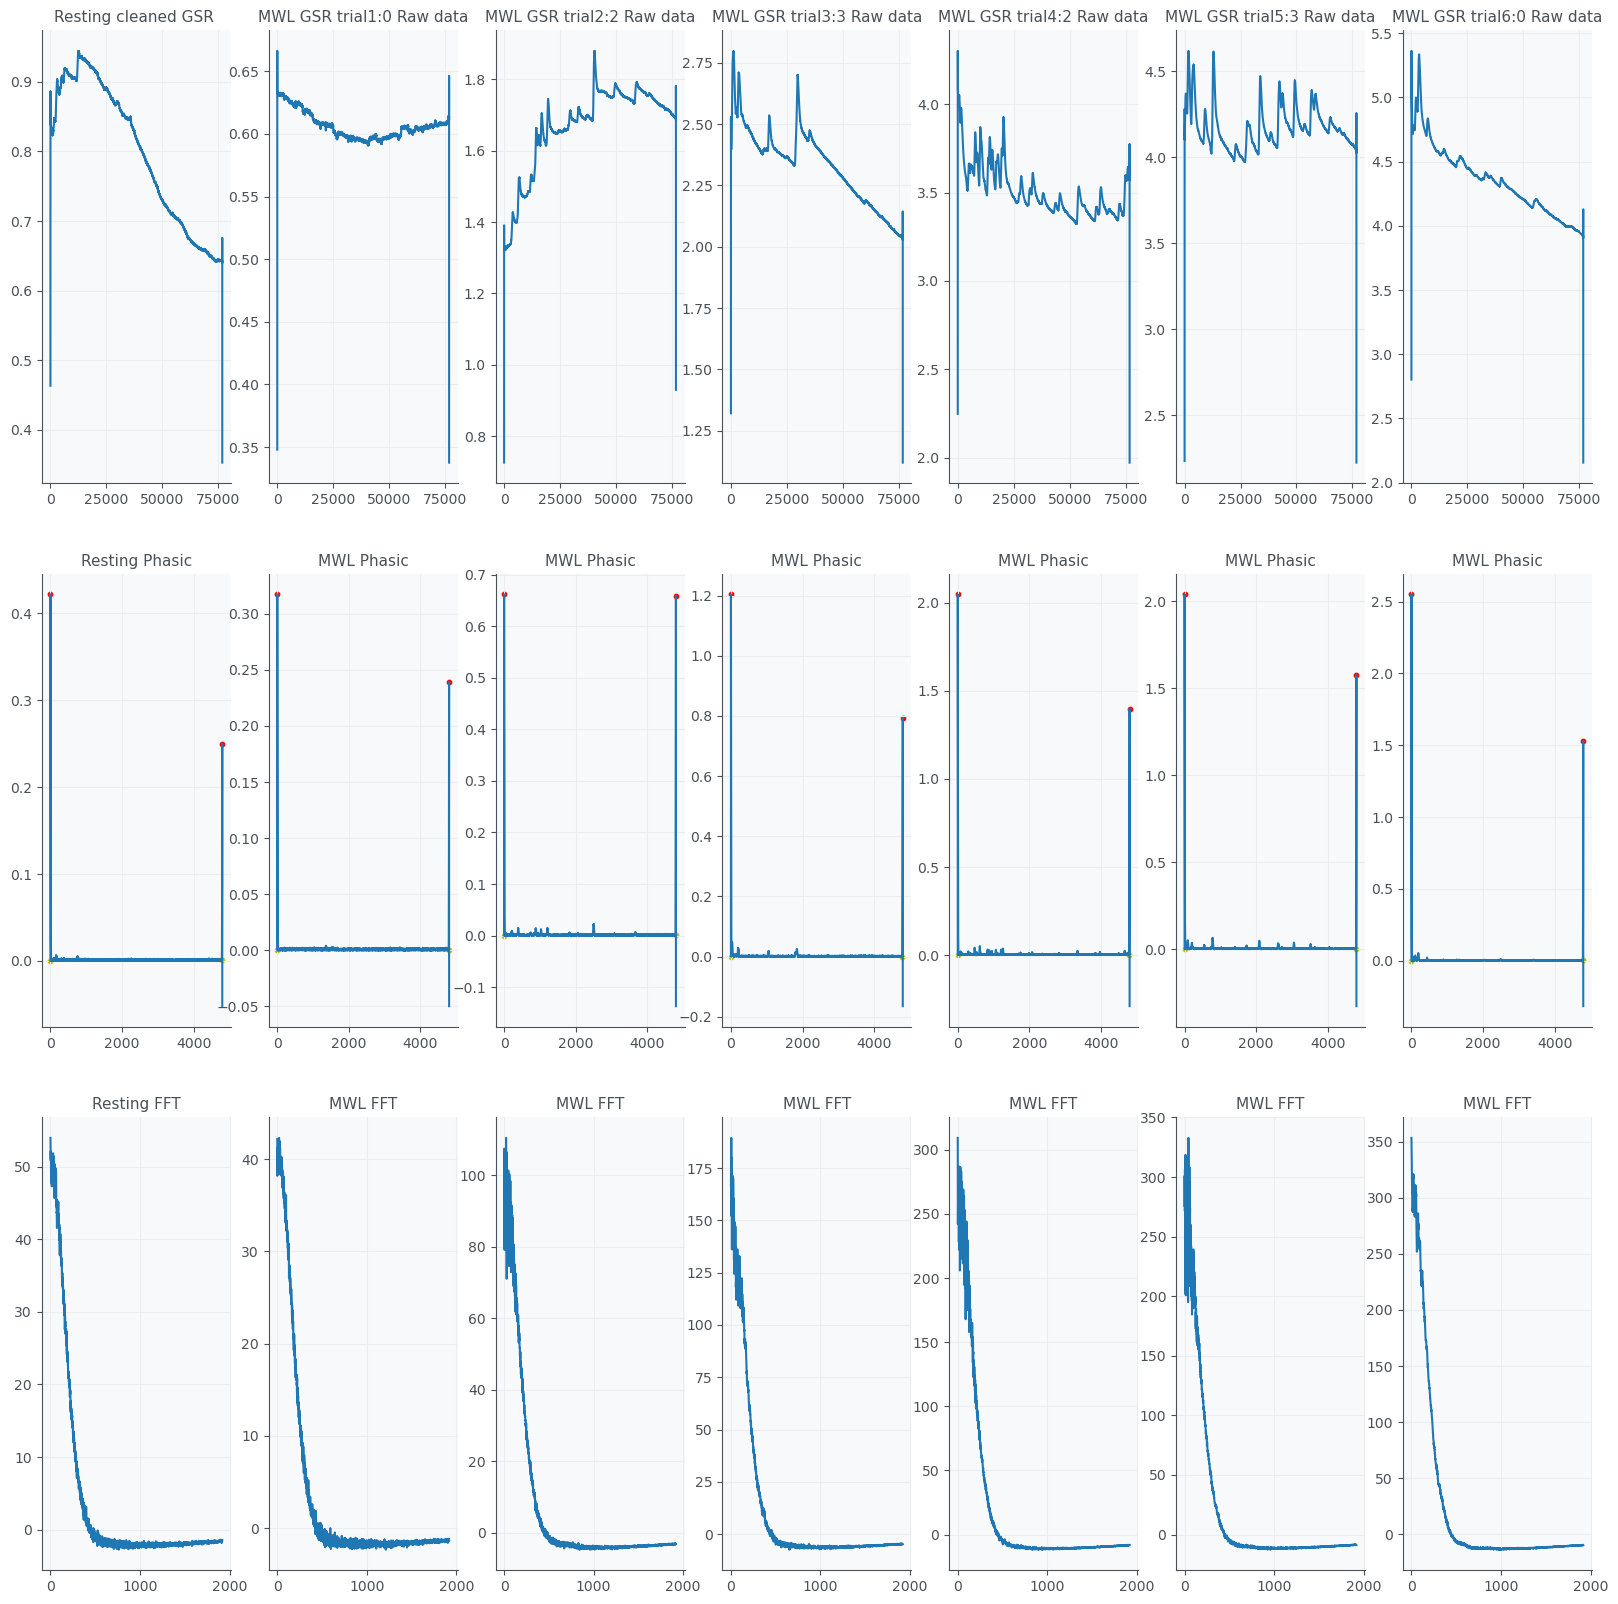

In [61]:
Display_MAUS_Dataset(10) 
"""
PSD at resting = 1.3874784278381655e-07
sympathetic at resting = 4.82476849203525e-10
sympatheticN at resting = 4.272102426996504e-05 

PSD at MWL trial1:0= 7.060856389092218e-08
sympathetic = 1.2494432526394743e-10
sympatheticN = 2.0821256135605644e-05 

PSD at MWL trial2:2= 8.698612852313582e-07
sympathetic = 4.308718170513909e-08
sympatheticN = 0.0015668434747357174 

PSD at MWL trial3:3= 3.2325799937377627e-06
sympathetic = 4.331123999319673e-08
sympatheticN = 0.0004143270083126932 

PSD at MWL trial4:2= 8.505738178858206e-06
sympathetic = 1.7387944922536265e-07
sympatheticN = 0.0008789220996265434 

PSD at MWL trial5:3= 9.883710736090778e-06
sympathetic = 4.2297322879321495e-07
sympatheticN = 0.0015533792078094501 

PSD at MWL trial6:0= 4.852666064119653e-06
sympathetic = 4.5890274231074364e-08
sympatheticN = 0.00011308917283051185 
"""

# Make windowing and split it

In [24]:
"""
   WindowGSR_Data_And_Extract_MeanMaxMinSlopPeakNumPeakMeanPeak25Peak50Peak75FFT
   
   This function takes signa and make windowing on it
   
   It Extracts some features from GSR signal which are Mean, max, min
   slop, peak number, peak mean, peak 25% percentile, peak 50% percentile ,
   peak 75% percentile and FFT then returns them 
   
"""

def WindowGSR_Data_And_Extract_MeanMaxMinSlopPeakNumPeakMeanPeak25Peak50Peak75FFT( a_x , a_plot=True , a_plot2=True ):
        
    # Change list to an array
    a_x = np.asarray(a_x)
    a_y = np.linspace(0, len(a_x)-1 , len(a_x) ) # Make a Y-axis to make it easy to know the point location in y axis when apllying a window on both of them
 
    
    # Get peaks of signal
    l_clean_sig , l_phasic , l_tonic , l_onset  , l_peak, l_rise_time = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime(  np.array(a_x) , 0.1 , False ) 
    
    # Make windowing on clean signal
    a_x = windowed_view( l_clean_sig , g_window_size , g_overlab )
    a_y = windowed_view( a_y , g_window_size , g_overlab )

    # Calculate mean, max and min
    l_mean  = np.mean( a_x , axis=-1 )   # Get mean of data
    l_max   = np.max ( a_x , axis=-1 )   # Get max  of data
    l_min   = np.min ( a_x , axis=-1 )   # Get min  of data
    
    # Calculate slop
    l_slope = ((a_x*a_y).mean(axis=-1) - a_x.mean()*a_y.mean(axis=-1)) / ((a_x**2).mean() - (a_y.mean())**2) # Linear regression slop
    
    # Calculate freqency features
    l_fft = []
    l_psd = []
    l_spectogram_sxx = []
    
    for i in range( len(l_mean) ): # Loop for each window
        l_temp_fft , l_temp_psd , l_temp_spectogram_sxx = Extract_frequency_Features( a_x[i] , a_plot=False )
        l_fft.append( l_temp_fft )
        l_psd.append( l_temp_psd )
        l_spectogram_sxx.append( l_temp_spectogram_sxx )
        
    
    l_peaks_numb = []
    l_peaks_mean = []
    l_peaks_25 = []
    l_peaks_50 = []
    l_peaks_75 = []
    l_sympathetic = []
    l_sympatheticN = []
    l_sum_of_peak_duration  = []  # Is the diffrence between two peaks
    l_sum_of_peak_magnitude = []  # Is the sum of magnitude of peaks
    l_sum_of_peak_area      = []  # Is the sum of peaks area (magnitude*duration)
    
    
    ####################### Extracting peaks features #####################
    
   
    for i in range( 0 , a_x.shape[0] ): # Loop number of windows times
        # First get peak for each window
        l_window_peaks = []  # Empty the peaks list
        for j in range( 0 , len(l_peak) ): # loop on peaks list to know peaks in this window
            if( l_peak[j] in a_y[i] ): # Check the peaks position , with the y-axis for the each window
                l_window_peaks.append(l_peak[j])
   
        # After getting all the peaks for this window, we will calculate it's number, mean, Percentile
        if( len(l_window_peaks) > 0 ): # Check if there is a peak
            l_peaks_numb.append( len(l_window_peaks) )
            l_peaks_mean.append( np.mean( l_clean_sig[l_window_peaks] ) )# Mean of peaks ampitude 
            l_sum_of_peak_magnitude.append( np.sum( l_clean_sig[l_window_peaks] ) ) # Sum the magnitude of peaks
            l_peaks_25.append( np.percentile(l_window_peaks , 25 ) )  # At which value 25% of dataset fall
            l_peaks_50.append( np.percentile(l_window_peaks , 50 ) )  # At which value 50% of dataset fall
            l_peaks_75.append( np.percentile(l_window_peaks , 75 ) )  # At which value 75% of dataset fall
            # Geting peaks duration
            l_peaks_duration = []
            l_peaks_area = []
            for k in range( len(l_window_peaks) - 1 ):
                l_peaks_duration.append( l_window_peaks[k+1] - l_window_peaks[k] ) # Calculate duration by subtracting the time between two peaks
                l_peaks_area.append( l_peaks_duration[-1]*l_clean_sig[k+1] ) # Calculate the area of peaks by multipling duration by magnitude
            l_sum_of_peak_duration.append( np.mean(l_peaks_duration) )# Sum all the durations 
            l_sum_of_peak_area.append( np.mean(l_peaks_area) )     # Sum all the areas 
            
        else:   # No peaks in this window
            l_peaks_numb.append(0)
            l_peaks_mean.append (0)
            l_sum_of_peak_magnitude.append(0)
            l_peaks_25.append(0)
            l_peaks_50.append(0)
            l_peaks_75.append(0)
            l_sum_of_peak_duration.append(0)
            l_sum_of_peak_area.append(0)
            
            
    if( a_plot == True ):
        # Plot phasic
        l_w_size = len(l_mean)
        
        plt.figure(figsize=(10, 20))
        for i in range(l_w_size):
            l_phasic_start    = int(i*(len(l_phasic))/l_w_size)
            l_phasic_end      = int((i+1)*(len(l_phasic))/l_w_size)
            l_clean_sig_start = int(i*(len(l_clean_sig))/l_w_size)
            l_clean_sig_end   = int((i+1)*(len(l_clean_sig))/l_w_size)
            
            # Plot cleaned signal
            plt.subplot( l_w_size , 3 ,  i*3 + 1  )
            plt.title( f'Cleaned {i+1}' )
            plt.plot( l_clean_sig[ l_clean_sig_start : l_clean_sig_end ] , color='green' )
            
            # Plot phasic signal
            plt.subplot( l_w_size  , 3 , i*3 + 2  )
            plt.title( f'Phasic {i+1}' )
            plt.plot( l_phasic[ l_phasic_start : l_phasic_end ] , color='blue'  )
            
            
            plt.subplot( l_w_size , 3 ,  i*3 + 3   )
            plt.title( f'FFT {i+1} ' )
            plt.plot( l_fft[i] , color='black')
            print( f'FFT of window {i+1} = {sum(l_fft[i])*10} '  )
            l_sympathetic.append( nk.eda_sympathetic( l_clean_sig[ l_clean_sig_start : l_clean_sig_end ] , sampling_rate=Fs )['EDA_Sympathetic'] )
            print( f'sympathetic = { l_sympathetic[-1] }' )
            l_sympatheticN.append( nk.eda_sympathetic( l_clean_sig[ l_clean_sig_start : l_clean_sig_end ] , sampling_rate=Fs )['EDA_SympatheticN'] )
            print( f'sympatheticN = { l_sympatheticN[-1] } \n' )
            
    if( a_plot2 == True ):
        
        plt.figure(figsize=(10, 20))
        plt.subplot( 12 , 1 , 1 )
        plt.title(' Mean ')
        plt.plot( l_mean.tolist() )
        plt.subplot( 12 , 1 , 2 )
        plt.title(' Max ')
        plt.plot( l_max.tolist() )
        plt.subplot( 12 , 1 , 3 )
        plt.title(' Min ')
        plt.plot( l_min.tolist() )
        plt.subplot( 12 , 1 , 4 )
        plt.title(' Slope ')
        plt.plot( l_slope.tolist() )
        plt.subplot( 12 , 1 , 5 )
        plt.title(' Peak numbers ')
        plt.plot( l_peaks_numb )
        plt.subplot( 12 , 1 , 6 )
        plt.title(' Peak mean ')
        plt.plot( l_peaks_mean )
        plt.subplot( 12 , 1 , 7 )
        plt.title(' Peak 25 ')
        plt.plot( l_peaks_25 )
        plt.subplot( 12 , 1 , 8 )
        plt.title(' Peak 50 ')
        plt.plot( l_peaks_50 )
        plt.subplot( 12 , 1 , 9 )
        plt.title(' Peak 75 ')
        plt.plot( l_peaks_75 )
        plt.subplot( 12 , 1 , 10 )
        plt.title(' FFT ')
        plt.plot( np.sum( l_fft , axis=-1 )  )
        plt.subplot( 12 , 1 , 11 )
        plt.title(' sympathetic ')
        plt.plot( l_sympathetic   )
        plt.subplot( 12 , 1 , 12 )
        plt.title(' sympatheticN ')
        plt.plot( l_sympatheticN  )
        

    
    return l_mean.tolist() , l_max.tolist() , l_min.tolist() , l_slope.tolist() , l_peaks_numb , l_peaks_mean , l_peaks_25 , l_peaks_50 , l_peaks_75 , l_sympathetic , l_sympatheticN , l_sum_of_peak_duration , l_sum_of_peak_magnitude , l_sum_of_peak_area , np.mean( l_fft , axis=-1).tolist() 


# Calculate the base line features

In [25]:
def calculate_base_line( a_signal ):

    fb = WindowGSR_Data_And_Extract_MeanMaxMinSlopPeakNumPeakMeanPeak25Peak50Peak75FFT( a_signal , a_plot=False , a_plot2=False  )

    global g_base_line_mean 
    global g_base_line_max 
    global g_base_line_min
    global g_base_line_slop 
    global g_base_line_peak_num
    global g_base_line_peak_mean
    global g_base_line_peak_25
    global g_base_line_peak_50 
    global g_base_line_peak_75
    global g_base_line_peak_duration 
    global g_base_line_peak_mag
    global g_base_line_peak_area 
    global g_base_line_fft

    g_base_line_mean = np.mean( fb[0] )
    g_base_line_max = np.mean( fb[1] )
    g_base_line_min = np.mean( fb[2] )
    g_base_line_slop = np.mean( fb[3] )
    g_base_line_peak_num = 0
    g_base_line_peak_mean = np.mean( fb[5] )
    g_base_line_peak_25 = np.mean( fb[6] )
    g_base_line_peak_50 = np.mean( fb[7] )
    g_base_line_peak_75 = np.mean( fb[8] )
    g_base_line_peak_duration = np.mean( fb[11] )
    g_base_line_peak_mag = np.mean( fb[12] )
    g_base_line_peak_area = np.mean( fb[13] )
    g_base_line_fft = np.mean( fb[14] )
    


In [26]:
# db = Get_dataFromTextFile( 'driving/data4.txt')
# calculate_base_line(db)


# Traing SVM model

In [27]:
"""

   This function gets the relative features according to base line features
   it returns : l_relative_mean , l_relative_max , l_relative_min  , l_relative_peaks_numb 
                l_relative_peaks_mean , l_relative_peaks_magnitude, l_relative_fft

"""
def Get_relative_feature_values( a_mean , a_max , a_min , a_slop , a_peaks_numb , a_peaks_mean  , a_peaks_25 ,a_peaks_50  \
                               ,a_peaks_75 , a_sum_peaks_duration , a_sum_of_peaks_magnitude , a_sum_of_peaks_area , a_fft):
    
    
    # Get the relative mean to use it in the model
    l_relative_mean = [ (l_x - g_base_line_mean)/g_base_line_mean  for l_x in a_mean[ : int(len(a_mean)) ] ]
    l_relative_mean

    # Get the relative max to use it in the model
    l_relative_max = [ (l_x-g_base_line_max)/g_base_line_max  for l_x in a_max[ : int(len(a_mean)) ] ]
    l_relative_max

    # Get the relative min to use it in the model
    l_relative_min = [ (l_x - g_base_line_min)/g_base_line_min  for l_x in a_min[ : int(len(a_mean)) ] ]
    l_relative_min

    # Get the relative slope to use it in the model (Not good)
#     l_average_r_slope = np.mean(a_slope)
#     l_relative_slope  = [ (l_x - l_average_r_slope)/l_average_r_slope  for l_x in a_slope[ : int(len(a_mean)) ] ]
    l_relative_slope = a_slop

    # Get the peak num difference to use it in the model
    l_relative_peaks_numb  = [ (l_x - g_base_line_peak_num)  for l_x in a_peaks_numb [ : int(len(a_peaks_numb)) ] ]
    l_relative_peaks_numb 

    # Get the relative peak mean to use it in the model
    l_relative_peaks_mean  = [ (l_x - g_base_line_peak_mean)/g_base_line_peak_mean  for l_x in a_peaks_mean[ : int(len(a_mean)) ] ]
    l_relative_peaks_mean

    """
      Peaks 25,50 and 75 not good
    """
    # Get the relative peak 25 to use it in the model
    l_relative_peaks_25  = [ (l_x - g_base_line_peak_25)/g_base_line_peak_25 for l_x in a_peaks_25[ : int(len(a_mean)) ] ]
    l_relative_peaks_25 

    # Get the relative peak 50 to use it in the model
    l_relative_peaks_50  = [ (l_x - g_base_line_peak_50)/g_base_line_peak_50 for l_x in a_peaks_50[ : int(len(a_mean)) ] ]
    l_relative_peaks_50 

    # Get the relative peak 75 to use it in the model
    l_relative_peaks_75  = [ (l_x - g_base_line_peak_75)/g_base_line_peak_75 for l_x in a_peaks_75[ : int(len(a_mean)) ] ]
    l_relative_peaks_75


    # Get the relative peak duration to use it in the model
    # First remove any nan values
    l_sum_peaks_duration = [l_x if not np.isnan(l_x) else 0 for l_x in a_sum_peaks_duration[ : int(len(a_mean)) ] ]
    l_relative_peaks_duration  = [ (l_x - g_base_line_peak_duration )/g_base_line_peak_duration for l_x in a_sum_peaks_duration[ : int(len(a_mean)) ]  ]
    l_relative_peaks_duration 

    # Get the relative peak magnitude to use it in the model(not good)
    # First remove any nan values
    l_sum_peaks_magnitude  = [l_x if not np.isnan(l_x) else 0 for l_x in a_sum_of_peaks_magnitude[ : int(len(a_mean)) ] ]
    l_relative_peaks_magnitude  = [ (l_x - g_base_line_peak_mag )/g_base_line_peak_mag for l_x in a_sum_of_peaks_magnitude[ : int(len(a_mean)) ]  ]
    l_relative_peaks_magnitude

    # Get the relative peak area to use it in the model(not good)
    # First remove any nan values
    l_sum_of_peaks_area   = [l_x if not np.isnan(l_x) else 0 for l_x in a_sum_of_peaks_area[ : int(len(a_mean)) ] ]
    l_relative_peaks_area   = [ (l_x - g_base_line_peak_area )/g_base_line_peak_area for l_x in a_sum_of_peaks_area[ : int(len(a_mean)/2) ]  ]
    l_relative_peaks_area 

    # Get the relative fft to use it in the model 
    l_relative_fft  = [ (l_x - g_base_line_fft)/g_base_line_fft  for l_x in a_fft[ : int(len(a_mean)) ]  ]
    l_relative_fft
    
    return l_relative_mean , l_relative_max , l_relative_min  , l_relative_peaks_numb ,l_relative_peaks_mean ,  \
           l_relative_peaks_magnitude, l_relative_fft
           
    
    

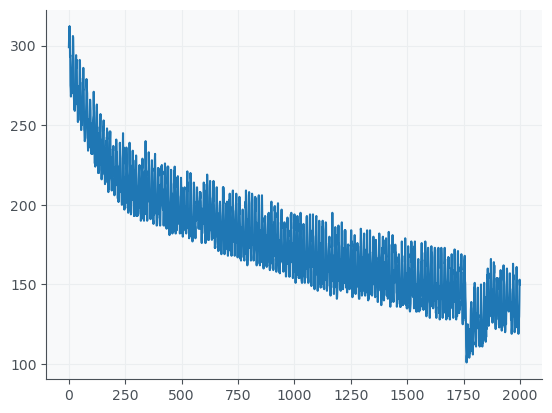

In [30]:
plt.plot(Focus_3)

### Getting signals and extract features from them

In [29]:
# Focusing data
Focus_1 = Get_dataFromTextFile( 'watching_lecture/TinyML_focus_4.txt')[2000:]
Focus_2 = Get_dataFromTextFile( 'play/Playing_piano_1.txt')[1300:]
Focus_3 = Get_dataFromTextFile('play/Playing_LR_focus_at_end_3.txt')[1000:] # Focuse at end
Focus_4 = Get_dataFromTextFile('driving/data3.txt')[500:]

# Distraction data
Distracted_1 = Get_dataFromTextFile( 'watching_lecture/Studing_DL_not_focus_1.txt')
Distracted_2 = Get_dataFromTextFile( 'play/Playing_LR_focus_at_end_3.txt')[0:1000]  # Distracted at start only
Distracted_3 = Get_dataFromTextFile( 'driving/taxi_dis_high_data6.txt')[1000:]

# Focusing features
Focus_features_1 = WindowGSR_Data_And_Extract_MeanMaxMinSlopPeakNumPeakMeanPeak25Peak50Peak75FFT( Focus_1  , a_plot=False , a_plot2=False  )
Focus_features_2 = WindowGSR_Data_And_Extract_MeanMaxMinSlopPeakNumPeakMeanPeak25Peak50Peak75FFT( Focus_2  , a_plot=False , a_plot2=False )
Focus_features_3 = WindowGSR_Data_And_Extract_MeanMaxMinSlopPeakNumPeakMeanPeak25Peak50Peak75FFT( Focus_3  , a_plot=False , a_plot2=False )
Focus_features_4 = WindowGSR_Data_And_Extract_MeanMaxMinSlopPeakNumPeakMeanPeak25Peak50Peak75FFT( Focus_4  , a_plot=False , a_plot2=False )

# Distraction features
Distraction_features_1 = WindowGSR_Data_And_Extract_MeanMaxMinSlopPeakNumPeakMeanPeak25Peak50Peak75FFT( Distracted_1 , a_plot=False , a_plot2=False) 
Distraction_features_2 = WindowGSR_Data_And_Extract_MeanMaxMinSlopPeakNumPeakMeanPeak25Peak50Peak75FFT( Distracted_2 , a_plot=False , a_plot2=False)
Distraction_features_3 = WindowGSR_Data_And_Extract_MeanMaxMinSlopPeakNumPeakMeanPeak25Peak50Peak75FFT( Distracted_3 , a_plot=False , a_plot2=False)

### Get realative features ###
# Focus
calculate_base_line( Get_dataFromTextFile( 'watching_lecture/Rest_TinyML_4.txt' ) )
relative_focus_features_1 = Get_relative_feature_values( Focus_features_1[0] , Focus_features_1[1] , Focus_features_1[2] , Focus_features_1[3] , Focus_features_1[4] , Focus_features_1[5] , Focus_features_1[6] , Focus_features_1[7] , Focus_features_1[8] , Focus_features_1[11] , Focus_features_1[12] , Focus_features_1[13] , Focus_features_1[14] )

calculate_base_line( Get_dataFromTextFile('play/Rest_playiny_piano_1.txt') )                    
relative_focus_features_2 = Get_relative_feature_values( Focus_features_2[0] , Focus_features_2[1] , Focus_features_2[2] , Focus_features_2[3] , Focus_features_2[4] , Focus_features_2[5] , Focus_features_2[6] , Focus_features_2[7] , Focus_features_2[8] , Focus_features_2[11] , Focus_features_2[12] , Focus_features_2[13] , Focus_features_2[14] )

calculate_base_line( Get_dataFromTextFile('play/Rest_playiny_LR_3.txt') )                    
relative_focus_features_3 = Get_relative_feature_values( Focus_features_3[0] , Focus_features_3[1] , Focus_features_3[2] , Focus_features_3[3] , Focus_features_3[4] , Focus_features_3[5] , Focus_features_3[6] , Focus_features_3[7] , Focus_features_3[8] , Focus_features_3[11] , Focus_features_3[12] , Focus_features_3[13] , Focus_features_3[14] )

calculate_base_line(Get_dataFromTextFile('driving/data3.txt')[0:500] )                    
relative_focus_features_4 = Get_relative_feature_values( Focus_features_4[0] , Focus_features_4[1] , Focus_features_4[2] , Focus_features_4[3] , Focus_features_4[4] , Focus_features_4[5] , Focus_features_4[6] , Focus_features_4[7] , Focus_features_4[8] , Focus_features_4[11] , Focus_features_4[12] , Focus_features_4[13] , Focus_features_4[14] )

# Distracted             
calculate_base_line( Get_dataFromTextFile('watching_lecture/Rest_Studing_DL.txt') )
relative_distractive_features_1 = Get_relative_feature_values( Distraction_features_1[0] , Distraction_features_1[1] , Distraction_features_1[2] , Distraction_features_1[3] , Distraction_features_1[4] , Distraction_features_1[5] , Distraction_features_1[6] , Distraction_features_1[7] , Distraction_features_1[8] , Distraction_features_1[11] , Distraction_features_1[12] , Distraction_features_1[13] , Distraction_features_1[14] )
calculate_base_line( Get_dataFromTextFile('play/Rest_playiny_LR_3.txt') )
relative_distractive_features_2 = Get_relative_feature_values( Distraction_features_2[0] , Distraction_features_2[1] , Distraction_features_2[2] , Distraction_features_2[3] , Distraction_features_2[4] , Distraction_features_2[5] , Distraction_features_2[6] , Distraction_features_2[7] , Distraction_features_2[8] , Distraction_features_2[11] , Distraction_features_2[12] , Distraction_features_2[13] , Distraction_features_2[14] )
calculate_base_line( Get_dataFromTextFile( 'driving/taxi_dis_high_data6.txt')[:1000] )
relative_distractive_features_3 = Get_relative_feature_values( Distraction_features_3[0] , Distraction_features_3[1] , Distraction_features_3[2] , Distraction_features_3[3] , Distraction_features_3[4] , Distraction_features_3[5] , Distraction_features_3[6] , Distraction_features_3[7] , Distraction_features_3[8] , Distraction_features_3[11] , Distraction_features_3[12] , Distraction_features_3[13] , Distraction_features_3[14] )


# Concaenate all the lists with each other
# Initialize an empty list to hold the concatenated lists
con = []

# Iterate over the indices of the lists within each tuple
for i in range(len(relative_focus_features_1)):
    # Concatenate the corresponding lists from each tuple and append the result to the concatenated_lists
    con.append( relative_focus_features_1[i] + relative_focus_features_2[i] + relative_focus_features_3[i] + relative_focus_features_4[i] + relative_distractive_features_1[i] + relative_distractive_features_2[i] + relative_distractive_features_3[i] )

X = np.column_stack( con )

# Number of false and true in the my data
true_number = len( relative_focus_features_1[0] )  + len( relative_focus_features_2[0] ) + len( relative_focus_features_3[0] ) + len( relative_focus_features_4[0] )  # Focus
false_number  = len( relative_distractive_features_1[0] )  + len( relative_distractive_features_2[0] ) + len( relative_distractive_features_3[0] ) # Distracted

Y = [1]*( true_number ) + [0]*(false_number)


C:\Users\mohammedhamdy32\anaconda3\Lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\mohammedhamdy32\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mohammedhamdy32\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### After extracting features train the model

In [31]:
# Step 3: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split( X , Y , test_size=0.2, random_state=42)

# Step 4: Import SVM model
svm_model = SVC(kernel='rbf')  # You can choose the appropriate kernel and other parameters

# Step 5: Train the SVM model
svm_model.fit(X_train, y_train)

# Step 6: Evaluate the model
accuracy = svm_model.score(X_test, y_test)

print("Accuracy:", accuracy)

Accuracy: 0.8292682926829268


In [32]:
features_array = np.array( [[10]*len(con)] )

predictions = svm_model.predict( features_array )
predictions

array([0])

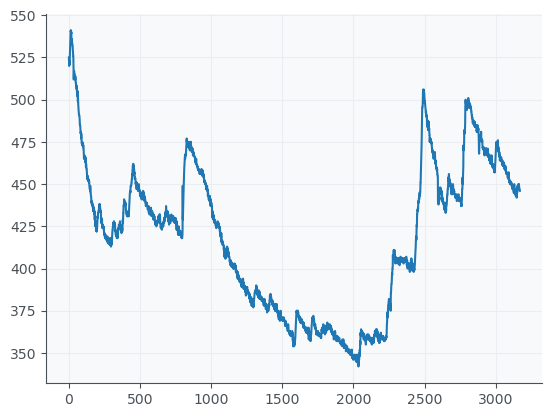

In [33]:
x = Get_dataFromTextFile( 'driving/taxi_dis_data9.txt')
plt.plot( x[230:] )

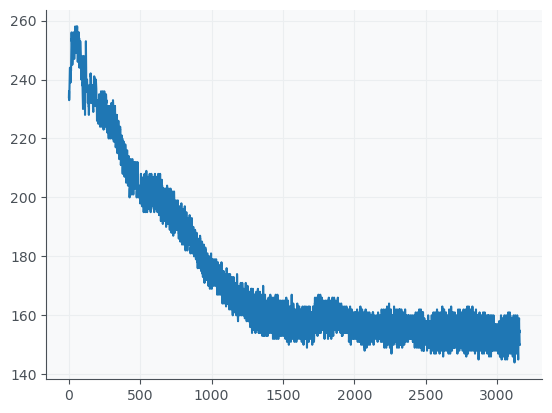

In [34]:
x = Get_dataFromTextFile( 'driving/Free_driving_data7.txt')
plt.plot( x[140:] )

In [598]:
features_array[0:5]

array([[ 0.03254313,  0.21449776, -0.36396276,  2.        , -0.07178454,
        -0.03685651, -0.19207573],
       [ 0.71680409,  0.69357301,  0.6426116 ,  2.        ,  0.72915663,
         0.79422344,  1.17647481],
       [ 0.86497027,  0.71037291,  1.15987749,  2.        ,  0.89836082,
         0.96979466,  0.99098368],
       [ 0.59434738,  0.5573829 ,  0.64190956,  0.        , -1.        ,
        -1.        ,  0.65521163],
       [ 0.39819044,  0.30020188,  0.52066994,  1.        ,  0.4580142 ,
        -0.24356093,  0.47010437]])

In [599]:
features_array[5:10]

array([[ 0.59435705,  0.84858799,  0.56569705,  1.        ,  1.07211425,
         0.07504315,  0.41748678],
       [ 0.95586492,  0.90121161,  1.13319173,  1.        ,  1.13187926,
         0.10605011,  1.19884945],
       [ 0.93605498,  1.03660399,  1.06219313,  1.        ,  1.28239251,
         0.18413858,  0.79006279],
       [ 0.94556216,  0.94511597,  0.99211106,  0.        , -1.        ,
        -1.        ,  0.98910808],
       [ 0.55571458,  0.44425987,  0.81725431,  1.        ,  0.52065314,
        -0.21106293,  0.51089891]])

In [600]:
features_array[10:15]

array([[ 0.72170484,  0.63486648,  0.83777216,  2.        ,  0.76763704,
         0.83415184,  0.88860869],
       [ 0.76967086,  0.63486648,  1.01656256,  0.        , -1.        ,
        -1.        ,  0.65428359],
       [ 0.85367637,  0.69294458,  1.01658681,  2.        ,  0.88332652,
         0.95419463,  1.18178553],
       [ 1.05407511,  1.26457343,  1.08814323,  2.        ,  1.47373262,
         1.56681725,  0.85546593],
       [ 1.2010055 ,  1.26457343,  1.35902489,  2.        ,  1.32950651,
         1.41716402,  0.664157  ]])

In [601]:
features_array[15:20]

array([[ 1.14906347,  0.98750673,  1.39372457,  2.        ,  1.17413083,
         1.25594168,  1.55953066],
       [ 0.81521651,  0.71787294,  1.01055206,  0.        , -1.        ,
        -1.        ,  0.84856656],
       [ 0.55356049,  0.44474736,  0.74769696,  0.        , -1.        ,
        -1.        ,  0.58241836],
       [ 0.35191795,  0.25429447,  0.54473565,  0.        , -1.        ,
        -1.        ,  0.36421287],
       [ 0.26797548,  0.13902534,  0.5101076 ,  0.        , -1.        ,
        -1.        ,  0.33083398]])

In [602]:
features_array[20:25]

array([[ 0.36358672,  0.24993779,  0.51147964,  1.        ,  0.39071074,
        -0.27847895,  0.52203306],
       [ 0.5841626 ,  0.52603569,  0.73354213,  1.        ,  0.67636351,
        -0.13027812,  0.83877616],
       [ 0.48843645,  0.43005108,  0.67613152,  0.        , -1.        ,
        -1.        ,  0.44635202],
       [ 0.41178693,  0.24373879,  0.67589345,  0.        , -1.        ,
        -1.        ,  0.51214845],
       [ 0.38653804,  0.23426937,  0.61613991,  0.        , -1.        ,
        -1.        ,  0.45632386]])

In [603]:
features_array[25:30]

array([[ 0.34300497,  0.2153762 ,  0.56670714,  1.        ,  0.3628376 ,
        -0.29293994,  0.50466263],
       [ 0.27897248,  0.13807695,  0.49638343,  0.        , -1.        ,
        -1.        ,  0.33152076],
       [ 0.20986727,  0.0736881 ,  0.43446716,  0.        , -1.        ,
        -1.        ,  0.24704663],
       [ 0.18239385,  0.12910825,  0.37591202,  1.        ,  0.26590281,
        -0.34323112,  0.05536218],
       [ 0.291051  ,  0.1436986 ,  0.50700978,  1.        ,  0.26590281,
        -0.34323112,  0.39236395]])

In [604]:
features_array[30:35]

array([[0.63869274, 0.94109042, 0.48487124, 1.        , 0.98216958,
        0.02837854, 0.62336735],
       [1.1049955 , 0.98931847, 1.34678917, 2.        , 1.20670449,
        1.28974106, 1.51172434],
       [1.29545266, 1.2744616 , 1.34678917, 3.        , 1.43786466,
        2.79439941, 1.45964641],
       [1.19140865, 1.2744616 , 1.19886043, 1.        , 1.55056514,
        0.32327046, 1.54902776],
       [0.74432387, 0.61424201, 1.00363526, 2.        , 0.71487665,
        0.77940612, 0.77448239]])

In [605]:
features_array[35:40]

array([[ 0.5115613 ,  0.44791885,  0.65221598,  0.        , -1.        ,
        -1.        ,  0.52882499],
       [ 0.28870544,  0.19062237,  0.48132317,  0.        , -1.        ,
        -1.        ,  0.29981322],
       [ 0.16403332,  0.05623536,  0.34066606,  0.        , -1.        ,
        -1.        ,  0.19772802],
       [ 0.0611882 , -0.04338747,  0.23606849,  0.        , -1.        ,
        -1.        ,  0.09470544],
       [-0.03191413, -0.12155938,  0.11359417,  0.        , -1.        ,
        -1.        ,  0.00151692]])

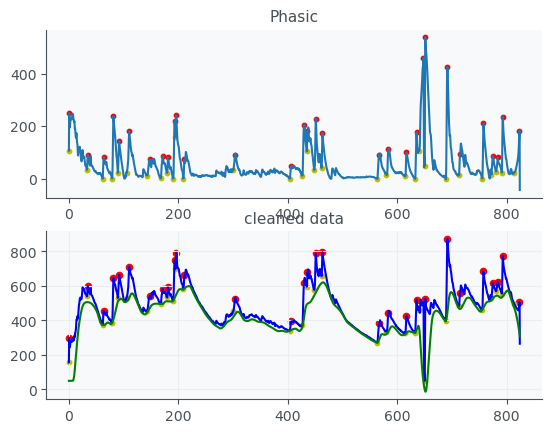

In [575]:
T1 = Get_dataFromTextFile( 'watching_lecture/Studing_DL_not_focus_1.txt')
Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( T1 , 0.1 , True )
s13 = Get_dataFromTextFile('watching_lecture/TinyML_Moderate_6.txt')

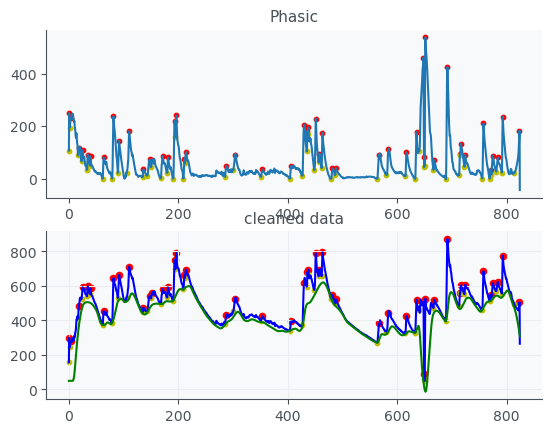

In [574]:
T1 = Get_dataFromTextFile( 'watching_lecture/Studing_DL_not_focus_1.txt')
Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( T1 , 0.05 , True )
s13 = Get_dataFromTextFile('watching_lecture/TinyML_Moderate_6.txt')

241.96133333333333

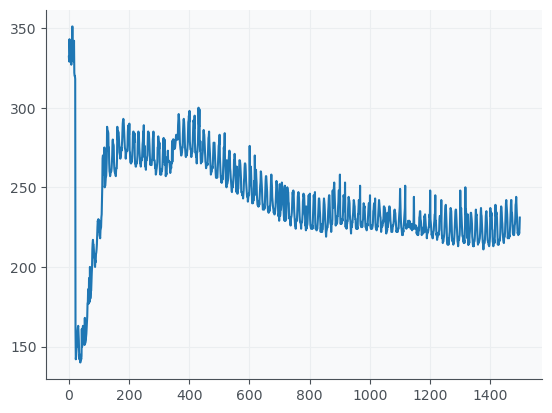

In [89]:
plt.plot( Rest_predict )
np.mean( Rest_predict )

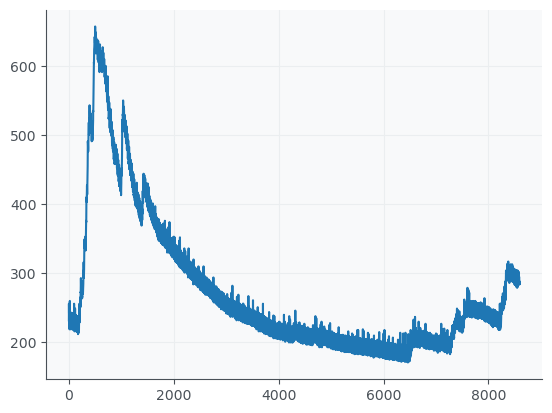

In [90]:
plt.plot( predict )

# Perdict a signal

In [137]:
Fs = 10

# 'watching_lecture/TinyML_Moderate_6.txt'
# 'watching_lecture/Rest_TinyML_6.txt'
# 'watching_lecture/TinyML_Moderate_7.txt'
# 'watching_lecture/Rest_TinyML_7.txt'
#  'watching_lecture/Rest_TinyML_4.txt'
# 'watching_lecture/TinyML_focus_4.txt'
# 'watching_lecture/Studing_DL_not_focus_1.txt'
# 'watching_lecture/Rest_Studing_DL.txt'

# 'driving/taxi_dis_high_data6.txt'
# 'driving/Free_driving_data8.txt'
# 'driving/data4.txt'

# First calculate baseline
Rest_predict  = Get_dataFromTextFile( 'watching_lecture/Rest_Studing_DL.txt' )
calculate_base_line( Rest_predict )

predict  =  Get_dataFromTextFile( 'watching_lecture/Studing_DL_not_focus_1.txt' )

x = predict
mean , maxx , minn , slope , peaks_numb , peaks_mean , peaks_25 , peaks_50 , peaks_75,_,_,sum_peaks_duration , sum_of_peaks_magnitude , sum_of_peaks_area , fft = WindowGSR_Data_And_Extract_MeanMaxMinSlopPeakNumPeakMeanPeak25Peak50Peak75FFT( x , False , False )

relative_mean , relative_maxx , relative_minn , relative_peaks_numb , relative_peaks_mean  , relative_sum_of_peaks_magnitude , relative_fft = Get_relative_feature_values( mean , maxx , minn , slope , peaks_numb , peaks_mean , peaks_25 , peaks_50 , peaks_75 , sum_peaks_duration , sum_of_peaks_magnitude , sum_of_peaks_area , fft )


C:\Users\mohammedhamdy32\anaconda3\Lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\mohammedhamdy32\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mohammedhamdy32\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[-0.08549249 -0.09301234 -0.41717896  1.          1.26302976  0.48529967
 -0.08858095]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


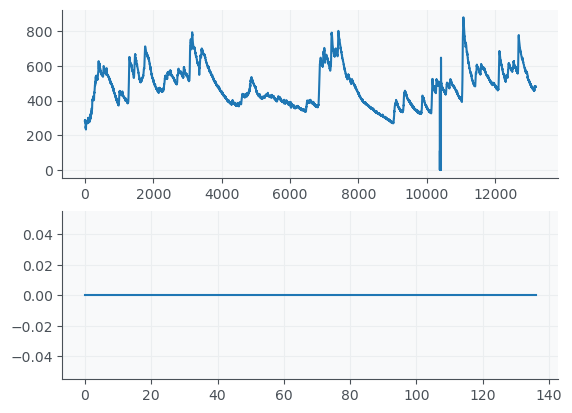

In [138]:
X = np.column_stack((relative_mean , relative_maxx , relative_minn , relative_peaks_numb , relative_peaks_mean , relative_sum_of_peaks_magnitude , relative_fft  ))
print( X[0] )
features_array = X

predictions = svm_model.predict( features_array )
print(predictions)

plt.subplot(2,1,1)
plt.plot(predict)
plt.subplot(2,1,2)
plt.plot(predictions)

# 1 means focus, 0 means dis

# The output of the model is predictions array

### Each number indicate a 12.8 sec

In [722]:
predictions

array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# Wavelet

In [20]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

# Generate a sample signal
signal  = Get_dataFromTextFile( 'MentalWorkLoad/Studing_control_and_solving_problems_5min_resting First.txt')


# Perform discrete wavelet transform (DWT)
wavelet = 'db5'  # Choose a wavelet function
level = 3        # Level of decomposition
coeffs = pywt.wavedec(signal[0:100] , wavelet, level=level)






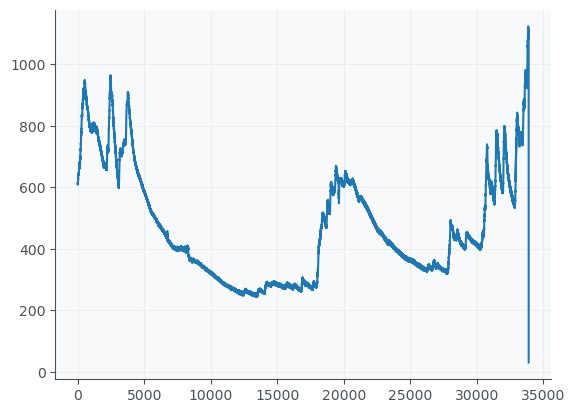

In [21]:
plt.plot(signal)

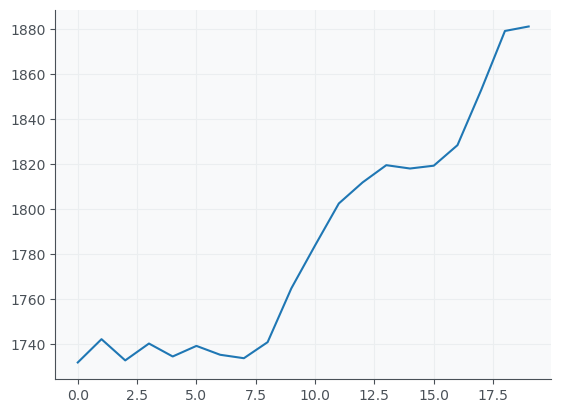

In [22]:
plt.plot(coeffs[0])


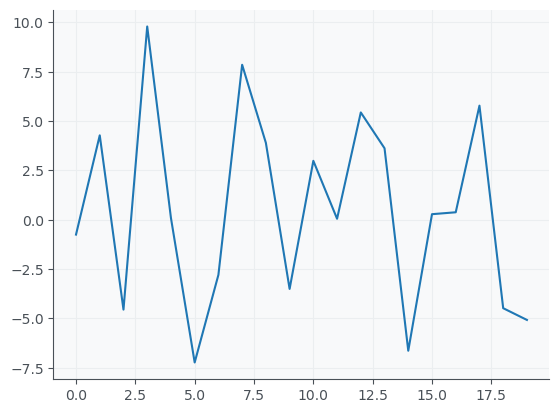

In [23]:
plt.plot(coeffs[1])

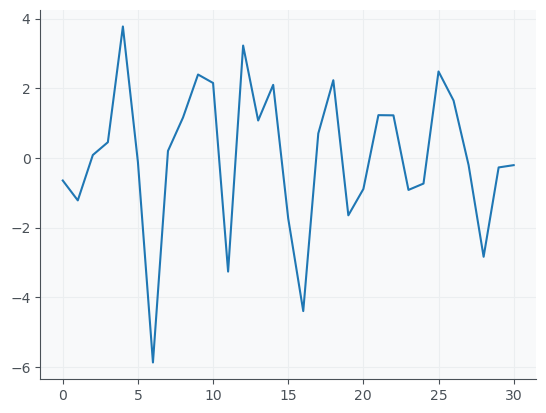

In [24]:
plt.plot(coeffs[2])

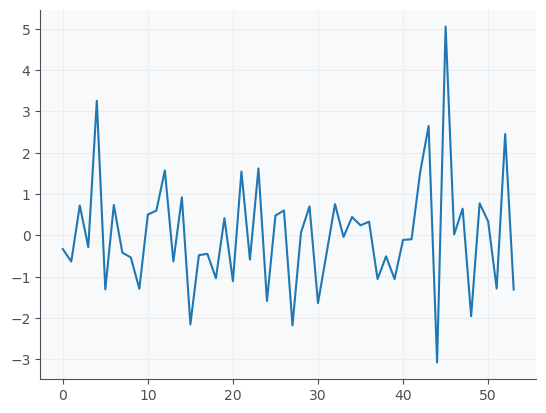

In [25]:
plt.plot(coeffs[3])

In [26]:
plt.plot(coeffs[4])

IndexError: list index out of range